In [942]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.signal import butter, filtfilt
import scipy as sc
import re

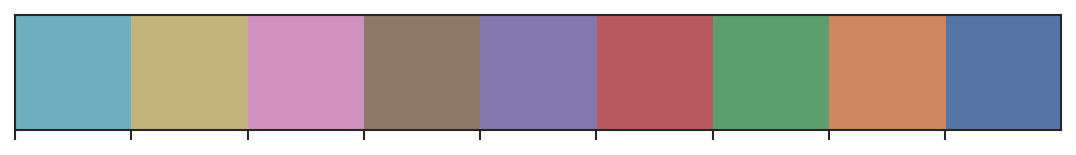

In [943]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 0.8)
colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

sns.palplot(colors)
plt.rcParams['axes.grid'] = True
#plt.rcParams['axes.grid.axis'] = 'y'
#plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-v0_8')

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [1129]:
def read_wave(file_path, resolution=np.int32):
    with wave.open(file_path, 'r') as wf:
        # Extract audio data
        n_frames = wf.getnframes()
        n_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()

        

        # Read frames and convert to numpy array
        frames = wf.readframes(n_frames)
        signal = np.frombuffer(frames, dtype=resolution) 
        signal = signal/np.max(np.abs(signal))
        signal = abs(signal)

        # If stereo, take only one channel
        if n_channels > 1:
            signal = signal[::n_channels]

        # Create time array
        time = np.linspace(0, n_frames / sample_rate, num=len(signal))
        

    return signal, sample_rate, time

@numba.njit(fastmath=True)
def signal_avg(signal, time, step):
    new_signal = []
    new_time = time[::step] 

    i = 0
    while i < len(signal):
        if i+10 < len(signal):
            new_signal.append(np.mean(signal[i:i+step]))
            i += step
        else:
            new_signal.append(np.mean(signal[i:]))
            i += step

    return new_time, new_signal

@numba.njit(fastmath=True)
def lin_fit(x, a, b):
    return a*x + b

@numba.njit(fastmath=True)
def p_func(x_list, threshold_l, threshold_h):

    p = np.zeros(len(x_list))

    for i in range(len(x_list)): 
        if i <= threshold_l:
            p[i] = 1
        elif i > threshold_l and i <= threshold_h:
            p[i] = 1/2 * (1 + np.cos(np.pi * (i - threshold_l) / (threshold_h - threshold_l + 1)))
        else:
            p[i] = 0 
        
    return p

@numba.njit(fastmath=True)
def interval_calc(bpm_i, bpm_f, p):
    c_start = 60 / bpm_i
    c_end = 60 / bpm_f
    c_i = p * c_start + (1 - p) * c_end
    return c_i


### Functions for signal smoothing ###

def running_mean(t, s, neigh):
    r_mean_s = []
    r_mean_t = []
    start_i = neigh
    for i in range(len(s) - neigh):
        i_col = i + start_i
        r_mean_s.append(np.mean(s[i:i_col+neigh]))
        r_mean_t.append(t[i_col])
    
    return np.array(r_mean_s), np.array(r_mean_t)

def lp_filter(signal, cutoff_frequency=100, sampling_rate=44100, filter_order=2):
    nyquist = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist
    b, a = butter(filter_order, normalized_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)



### Processing and grouping data ###

def synchro(met_tuple, exp_tuple):
    ### THIS ASSUMES THAT PARTICIPANTS CLAP AT THE FIRST BEEP OF THE METRONOME ### 

    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple
    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple
    s_met = np.array(s_met)
    s_exp = np.array(s_exp)
    t_met = np.array(t_met)
    t_exp = np.array(t_exp)


    min_val_met = min(f_met)
    min_index_met = np.where(f_met == min_val_met)[0][0]

    min_val_exp = min(f_exp)
    min_index_exp = np.where(f_exp == min_val_exp)[0][0]
    
    # Masking peak data of metronome
    mask_met = pt_met >= ft_met[min_index_met]
    mask_exp = pt_exp >= ft_exp[min_index_exp]
    

    first_met_pt = pt_met[mask_met][0]
    first_exp_pt = pt_exp[mask_exp][0]
    mask_met_t = t_met >= first_met_pt
    mask_exp_t = t_exp >= first_exp_pt


    # Adjusting signal and times
    t_met = t_met[mask_met_t]
    s_met = s_met[mask_met_t]
    t_met = t_met - t_met[0]

    # Adjusting peaks and peak-times
    pt_met = pt_met[mask_met]
    p_met = p_met[mask_met]
    pt_met = pt_met - pt_met[0]


    # Adjusting signal and time
    t_exp = t_exp[mask_exp_t]
    s_exp = s_exp[mask_exp_t]
    t_exp = t_exp - t_exp[0]

    # Adjusting peaks and peak-times
    pt_exp = pt_exp[mask_exp]
    p_exp = p_exp[mask_exp]
    pt_exp = pt_exp - pt_exp[0]


    #### Cutting off a desired number of claps (DOESNT WORK) ###
    #pt_met = pt_met[cut:]
    #pt_save = pt_met[0]
    #pt_met = pt_met - pt_save
    #p_met = p_met[cut:]

    #s_met = s_met[t_met >= pt_save]
    #t_met = t_met[t_met >= pt_save]
    #t_met = t_met - t_met[0]
   
    f_met = 1/np.diff(pt_met)
    ft_met = pt_met[1:]


    ### Synchoronizing the metronome and the experimental data
    #p_exp = p_exp[pt_exp >= pt_save]
    #pt_exp = pt_exp[pt_exp >= pt_save]
    #pt_exp = pt_exp - pt_save

    #s_exp = s_exp[t_exp >= pt_save]
    #t_exp = t_exp[t_exp >= pt_save]

    #t_exp = t_exp - pt_save


    f_exp = 1/np.diff(pt_exp)
    ft_exp = pt_exp[1:]



    re_met_tuple = t_met, s_met, pt_met, p_met, ft_met, f_met
    re_exp_tuple = t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp
    
    return re_met_tuple, re_exp_tuple

def avg_calc(met_tuple, exp_tuple):

    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple
    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple 

    # Calculating bin edges for time intervals to take the average of the peak times in
    bin_edges = (pt_met[:-1] + pt_met[1:])/2

    # Add start and end point
    start_diff = bin_edges[1] - bin_edges[0]
    end_diff = bin_edges[-1] - bin_edges[-2]
    bin_edges = np.pad(bin_edges, (1,1), 'constant', constant_values=(bin_edges[0] - start_diff, bin_edges[-1] + end_diff))
    bin_widths = np.diff(bin_edges)
    fail = 0

    avg_val = []
    std_val = []

    for i in range(len(bin_edges) - 1):
        mask = (pt_exp > bin_edges[i]) & (pt_exp < bin_edges[i+1])
        masked_data = pt_exp[mask]
    
        if len(masked_data) > 0:
            avg = np.mean(masked_data)
            std = np.std(masked_data)
            std = std / bin_widths[i]
            
            avg_val.append(avg)
            std_val.append(std)

        else:
            fail += 1
            continue

    avg_val = np.array(avg_val)
    #avg_per = avg_val[1:] - avg_val[:-1]
    avg_per = np.diff(avg_val)
    avg_freq = 1/avg_per


    t_err = []
    for i in range(len(std_val)-1):
        t_err_i = np.sqrt(std_val[i]**2 + std_val[i+1]**2)
        t_err.append(t_err_i)

    freq_err = []

    for i in range(len(t_err)): 
        freq_err_i = np.sqrt(1/avg_per[i]**2 * t_err[i]**2)
        freq_err.append(freq_err_i)


    return avg_freq, freq_err, avg_per, fail, avg_val, std_val

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def deviation_func(data_list, thr_l, thr_h): 
    
    data_met_dev = []
    start_dev_list = []
    trans_dev_list = []
    end_dev_list = []

    time_dev_list = []
    time_start_dev_list = []
    time_trans_dev_list = []
    time_end_dev_list = []
    std_list = []
    

    for i in range(len(data_list)):
        

        deviation = ((data_list[i][0] - data_list[i][2]))
        dev_start = deviation[:thr_l - 1]

        
        dev_trans = deviation[thr_l - 1 : thr_h - 1]
        dev_end = deviation[thr_h - 1:]


        data_met_dev.append(deviation)
        start_dev_list.append(np.mean(dev_start))
        trans_dev_list.append(np.mean(dev_trans))
        end_dev_list.append(np.mean(dev_end))

        time_dev = data_list[i][10][1:]- data_list[i][8][1:]
        time_dev_list.append(time_dev)
        time_start_dev_list.append(weighted_avg_and_std(time_dev[:thr_l], data_list[i][11][:thr_l]))
        time_trans_dev_list.append(weighted_avg_and_std(time_dev[thr_l:thr_h], data_list[i][11][thr_l : thr_h]))
        time_end_dev_list.append(weighted_avg_and_std(time_dev[thr_h:],data_list[i][11][thr_h:]))
        std_list.append(data_list[i][11])

                                   



    dev_tuple = (data_met_dev, start_dev_list, trans_dev_list, end_dev_list, time_dev_list, time_start_dev_list, time_trans_dev_list, time_end_dev_list, std_list)

    return dev_tuple

def deviation_plot(data_list, dev_tuple, thr_l=24, thr_h=48, max_beats=72):

    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
    ax = ax.flatten()
    
    # Metronome bpm values
    low = 80
    mid = 120
    high = 160
    bpm_list = [(low, mid), (low, high), (mid, low), (mid, high), (high, low), (high, mid)]

    counter = 0

    props = dict(boxstyle='round', facecolor='white', edgecolor = 'k', alpha=0.7, pad = 0.5)

    for i in range(len(ax)):
        if i % 4 != 0:

            low_cap =  thr_l / (bpm_list[counter][0] / 60 )
            high_cap = (max_beats - thr_h) / (bpm_list[counter][1] / 60 )
            
            met_filenames = ['low_mid', 'low_high',
                            'mid_low', 'mid_high',
                            'high_low', 'high_mid']

            name = met_filenames[counter].split('_')
            finished_name = ''
            for n in name:
                n = n.upper()
                finished_name += n + ' to '

            finished_name = finished_name[:-3]
            


            ax[i].errorbar(data_list[counter][3], dev_tuple[0][counter], yerr = data_list[counter][1],  marker='.', ls='', elinewidth=0.5, markersize=5, capsize=1, capthick=0.5)
            ax[i].set(xlabel = ('Time [s]'), ylabel = (r'$\Delta f$ [Hz]'))
            ax[i].set_title(finished_name)
            ax[i].set_ylim(-0.55,0.55)


            # Color blocking
            ax[i].axvspan(data_list[counter][3][0], low_cap, color='green', alpha=0.1)
            #ax[i].axvspan(low_cap, high_cap, color='yellow', alpha=0.1)
            ax[i].axvspan(data_list[counter][3][-1] - high_cap, data_list[counter][3][-1], color='red', alpha=0.1)

            # adding box with different deviations 
            textstr = '\n'.join((
                r'$\Delta f_{start}=%.2f$' % (dev_tuple[1][counter]),
                r'$\Delta f_{trans}=%.2f$' % (dev_tuple[2][counter]),
                r'$\Delta f_{end}=%.2f$' % (dev_tuple[3][counter])))

            ax[i].text(0.38, 0.75, textstr, transform=ax[i].transAxes, fontsize=8, bbox=props)

            counter += 1

        else: 
            ax[i].set_visible(False)

    fig.tight_layout()
    #plt.show() 

    return fig, ax



### Data extract using low-pass filter (fast) ###
def data_extract_lp(file, resolution, cutoff_frequency, height_var, prominence_var):
    signal, sample_rate, time = read_wave(file, resolution)

    ### LOW-PASS FILTER (FAST) ###
    signal = lp_filter(signal, cutoff_frequency)


    peak_indicies = sc.signal.find_peaks(signal, height=height_var, prominence=prominence_var)[0]
    peak_times = time[peak_indicies]
    peaks = signal[peak_indicies]

    #peak_times, peaks = peak_finder_neigh(time, signal, neigh_peak, threshold)

    freq_list = 1/np.diff(peak_times)
    freq_tlist = peak_times[1:]

    return time, signal, peak_times, peaks, freq_tlist, freq_list

### Data extract using running mean (slow) ###
def data_extract_rm(file, resolution, neigh_rm, height_var, prominence_var):
    signal, sample_rate, time = read_wave(file, resolution)
    
    ### RUNNING MEAN (SLOW) ###
    signal, time = running_mean(time, signal, neigh_rm)


    peak_indicies = sc.signal.find_peaks(signal, height=height_var, prominence=prominence_var)[0]
    peak_times = time[peak_indicies]
    peaks = signal[peak_indicies]

    #peak_times, peaks = peak_finder_neigh(time, signal, neigh_peak, threshold)

    freq_list = 1/np.diff(peak_times)
    freq_tlist = peak_times[1:]

    return time, signal, peak_times, peaks, freq_tlist, freq_list


### Quick extraction of data using low-pass filter ###
def final_data_lp_added(
                  filename1, 
                  filename2, 
                  resolution=(np.int16, np.int16), 
                  cutoff_frequency=(100, 100), 
                  height=(0.05, 0.05), 
                  prominence=(0.1, 0.1),
                  cut = 7
                  ):
    
    met_tuple = data_extract_lp(f'lydfiler/metronomfiler/{filename1}.wav', 
                                resolution[0], 
                                cutoff_frequency[0], 
                                height[0], 
                                prominence[0])
    

    exp_tuple = data_extract_lp(f'lydfiler/{filename2}.wav', 
                                resolution[1], 
                                cutoff_frequency[1], 
                                height[1], 
                                prominence[1])

    met_tuple, exp_tuple = synchro(met_tuple, exp_tuple)
    avg_freq, freq_err, avg_per, fail, avg_val, std_val = avg_calc(met_tuple, exp_tuple)

    if fail > 0:
        print(fail)
        print(filename2)
        

    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple
    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple

    x = np.cumsum(avg_per)

    ### REMOVING FIRST 8 CLAPS ###
    pt_met = pt_met[cut:]
    p_met = p_met[cut:]
    ft_met = ft_met[cut:]
    f_met = f_met[cut:]
    x = x[cut:]


    avg_freq = avg_freq[cut:]
    freq_err = freq_err[cut:]
    avg_val = avg_val[cut:]
    std_val = std_val[cut + 1:]

    print(len(pt_met), len(avg_val))

    return avg_freq, freq_err, f_met, x, t_exp, s_exp, pt_exp, p_exp, pt_met, p_met, avg_val, std_val

### Quick extraction of experimental data using lp-filter ###
def experiment_data_ext(file_extensions, res, cts, height_met, height_exp, prom_met, prom_exp):
    exp_data_list = []
    ct_met, ct_exp = cts

    standard_filenames = ['lm_n', 'lh_n', 'ml_n', 'mh_n', 'hl_n', 'hm_n']
    standard_met_filenames = ['low_mid', 'low_high', 'mid_low', 'mid_high', 'high_low', 'high_mid']

    met_filenames = [standard_met_filenames[i] + '_inc_thres' for i in range(len(standard_met_filenames))]

    exp_filenames = [str(file_extensions[0]) + standard_filenames[i] + str(file_extensions[1]) for i in range(len(standard_filenames))]

    for i, name in enumerate(exp_filenames):
        synced_data = final_data_lp_added(met_filenames[i], 
                                     name, 
                                     resolution=res, 
                                     cutoff_frequency=(ct_met, ct_exp), 
                                     height=(height_met[i], height_exp[i]), 
                                     prominence=(prom_met[i], prom_exp[i]))
        

        exp_data_list.append(synced_data)

    return exp_data_list

### Plotting quick-extracted data ###
def exp_data_plot_func(data_list):
    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)


    counter = 0
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):

            if i == 0 and j == 1: 
                met_label = 'Metronome'
                exp_label = 'Experimental data'
                func_label = 'Transition function'
                
            else: 
                met_label = '_nolegend_'
                exp_label = '_nolegend_'
                func_label = '_nolegend_'
            ### Defining metronome values ###
            if i != j:

                low = 80
                mid = 120
                high = 160

                # 3x3 bpm matrix
                bpm = np.array([[(low, low), (low, mid), (low, high)],
                                [(mid, low), (mid, mid), (mid, high)],
                                [(high, low), (high, mid), (high, high)]])
                # set diag = 0
                for k in range(3):
                    bpm[k,k] = (0, 0)
                
                threshold_l = 24
                threshold_h = 48

            #################################

            
            ### Calculating sigmoid function ###
                sig_x = np.linspace(data_list[counter][3][0], data_list[counter][3][-1], len(data_list[counter][3]))
                p_list = p_func(sig_x, threshold_l - 7, threshold_h - 7)
                sig_y = 1 / interval_calc(*bpm[i,j], p_list)

            ###################################

                met_filenames = ['low_mid', 'low_high',
                 'mid_low', 'mid_high',
                 'high_low', 'high_mid']

                name = met_filenames[counter].split('_')
                finished_name = ''
                for n in name:
                    n = n.upper()
                    finished_name += n + ' to '

                finished_name = finished_name[:-3]
        

            ### Plotting data ###
                ax[i,j].errorbar(data_list[counter][3], data_list[counter][0], yerr=data_list[counter][1], label = exp_label, marker='.', ls='', elinewidth=0.5, markersize=5, capsize=1, capthick=0.5)
                ax[i,j].plot(data_list[counter][3], data_list[counter][2], label = met_label, marker='.', ls='', color='red', alpha=0.5)
                ax[i,j].set(xlabel = ('Time [s]'), ylabel = ('Frequency [Hz]'))
                ax[i,j].set_title(finished_name)
                ax[i,j].plot(data_list[counter][3], sig_y, ls='--', marker='', linewidth=0.8, color='k', alpha=1, label = func_label)
                ax[i,j].set_ylim(1, 4.5)

                counter += 1
            else: 
                ax[i,j].set_visible(False)

            ###################################


    fig.tight_layout()
    fig.legend(loc='center', bbox_to_anchor=(0.5, 0.5), ncol=1, fontsize=12)

    return fig, ax


def time_deviation_plot(data_list, dev_tuple, thr_l=24, thr_h=48, max_beats=72):

    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
    ax = ax.flatten()
    
    # Metronome bpm values
    low = 80
    mid = 120
    high = 160
    bpm_list = [(low, mid), (low, high), (mid, low), (mid, high), (high, low), (high, mid)]

    counter = 0

    props = dict(boxstyle='round', facecolor='white', edgecolor = 'k', alpha=0.7, pad = 0.5)

    for i in range(len(ax)):

        if i == 2:
            light_blue_label = 'Initiation Period'
            green_label = 'Initial Period'
            white_label = 'Transition Period'
            blue_label = 'Final Period'
            dev_label = 'Phase Deviation'
                
        else: 
            light_blue_label = '_nolegend_'
            green_label = '_nolegend_'
            white_label = '_nolegend_'
            blue_label = '_nolegend_'
            dev_label = '_nolegend_'
    
                
        if i % 4 != 0:

            low_cap =  (thr_l) / (bpm_list[counter][0] / 60 )
            high_cap = (max_beats - thr_h) / (bpm_list[counter][1] / 60 )

            met_filenames = ['low_mid', 'low_high',
                              'mid_low', 'mid_high',
                              'high_low', 'high_mid']

            name = met_filenames[counter].split('_')
            finished_name = ''
            for n in name:
                n = n.upper()
                finished_name += n + ' to '

            finished_name = finished_name[:-3]

            # Color blocking
            ax[i].axvspan(0, data_list[counter][3][0], color=colors[0], alpha=0.2, label = light_blue_label)
            ax[i].axvspan(data_list[counter][3][0], low_cap, color=colors[6], alpha=0.2, label = green_label)
            ax[i].axvspan(low_cap, data_list[counter][3][-1] - high_cap, color='grey', alpha=0.1, label = white_label)
            ax[i].axvspan(data_list[counter][3][-1] - high_cap, data_list[counter][3][-1], color=colors[8], alpha=0.2, label = blue_label)
        

            ax[i].errorbar(data_list[counter][3], dev_tuple[4][counter], yerr = data_list[counter][-1], label = dev_label, marker='.', ls='', elinewidth=0.5, markersize=5, capsize=1, capthick=0.5)

            ax[i].set(xlabel = ('Time [s]'), ylabel = (r'$\Delta t$ [s]'))
            ax[i].set_title(finished_name)
            ax[i].set_ylim(-0.55,0.55)

            #ax[i].fill_between((0, dev_tuple[4][counter][8]), -0.2, 0.2, color=colors[0], alpha=0.2, label = light_blue_label)
            #ax[i].fill_between((dev_tuple[4][counter][8], dev_tuple[4][counter][trans_start -1]), -0.2, 0.1, color=colors[6], alpha=0.2, label = green_label)
            #ax[i].fill_between((dev_tuple[4][counter][trans_start -1], dev_tuple[4][counter][trans_end + 1]), -0.2, 0.1, color='grey', alpha=0.1, label = white_label)
            #ax[i].fill_between((dev_tuple[4][counter][trans_end + 1], dev_tuple[4][counter][-1]), -0.2, 0.1, color=colors[8], alpha=0.2, label = blue_label)


            # adding box with different deviations 
            textstr = '\n'.join((
                r'$\Delta t_{start}: \mu = %.2f, \sigma = %.2f$' % (dev_tuple[5][counter][0], dev_tuple[5][counter][1]),
                r'$\Delta t_{trans}: \mu = %.2f, \sigma = %.2f$' % (dev_tuple[6][counter][0], dev_tuple[6][counter][1]),
                r'$\Delta t_{end}: \mu = %.2f, \sigma = %.2f$' % (dev_tuple[7][counter][0], dev_tuple[7][counter][1])
                ))

            ax[i].text(0.3, 0.75, textstr, transform=ax[i].transAxes, fontsize=8, bbox=props)

            counter += 1

        else: 
            ax[i].set_visible(False)

    fig.legend(loc='center', bbox_to_anchor=(0.5, 0.5), ncol=1, fontsize=12)
    fig.tight_layout()
    #plt.show() 

    return fig, ax

In [1113]:
read_wave('lydfiler/metronomfiler/low_high.wav', resolution=np.int32)[1]

44100

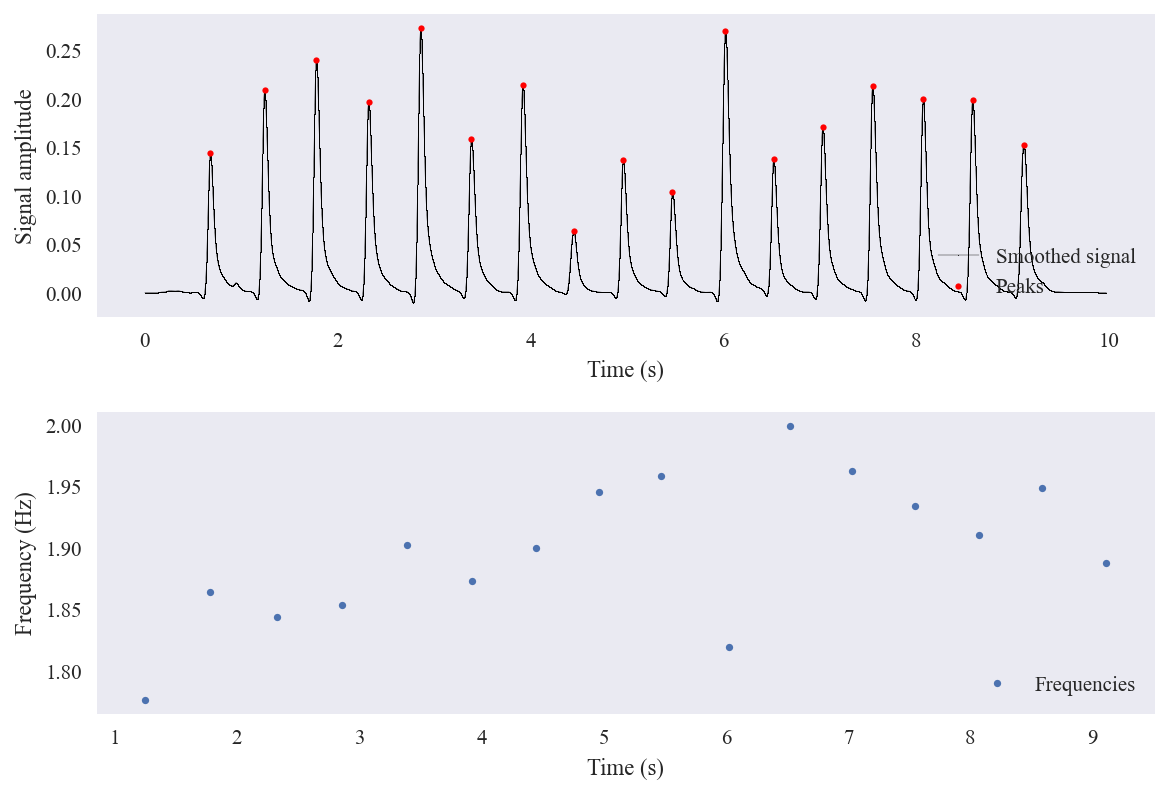

In [1114]:
new_time, new_signal, peak_times, peaks, freq_tlist, freq_list = data_extract_lp('trial.wav',
                                                                                   resolution=np.int32, 
                                                                                   cutoff_frequency=10, 
                                                                                   height_var=0.05,
                                                                                   prominence_var=0.02)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(new_time, 
           new_signal, 
           color='black', 
           ls='-', 
           marker='.', 
           linewidth = 0.2, 
           markersize=0.8, 
           label='Smoothed signal')


ax[0].plot(peak_times, peaks, color='red', ls='', marker='o', markersize=3, label='Peaks')
ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].legend(loc='lower right')
#ax[0].set_xlim(5.9,6.1)

ax[1].plot(freq_tlist, freq_list, '.', label='Frequencies')
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].legend(loc='lower right')

fig.tight_layout()

Sigrid and Niels clapping to the low mid metronome 

In [1115]:
ns_tuple_lm = data_extract_lp('lydfiler/Niels_Sigrid/Niels_og_Sigrid.wav', 
                               resolution=np.int32, 
                               cutoff_frequency=100, 
                               height_var=0.05,
                               prominence_var=0.001)

met_tuple_lm = data_extract_lp('lydfiler/metronomfiler/low_mid.wav', 
                                resolution=np.int32, 
                                cutoff_frequency=100, 
                                height_var=0.05,
                                prominence_var=0.01)

t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple_lm
t_ns, s_ns, pt_ns, p_ns, ft_ns, f_ns = ns_tuple_lm

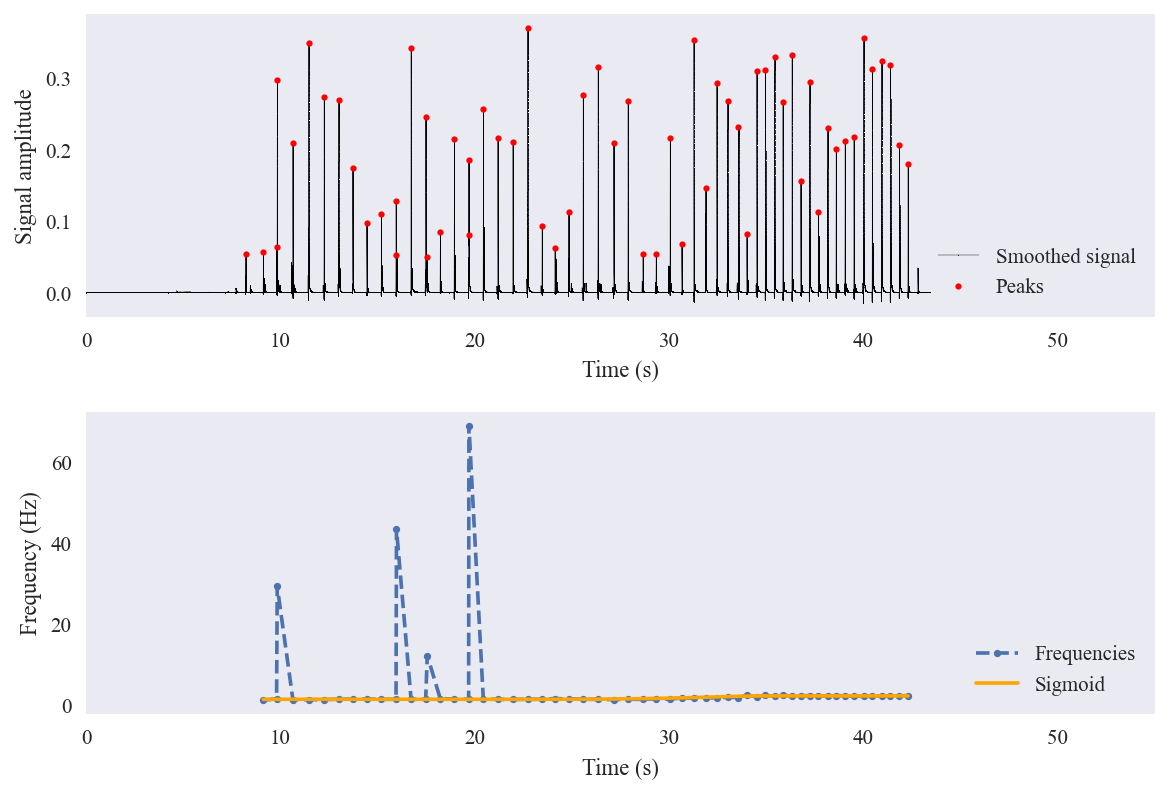

In [1116]:
sig_x = np.linspace(9, ft_ns[-1], len(ft_ns))
p_list = p_func(sig_x, threshold_l = 24, threshold_h = 40)
sig_y = 1 / interval_calc(80,130, p_list)


fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(t_ns, s_ns, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Smoothed signal')
ax[0].plot(pt_ns, p_ns, color='red', ls='', marker='o', linewidth = 0.2, markersize=3, label='Peaks')
ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].set_xlim(0,55)
ax[0].legend(loc='lower right')

ax[1].plot(ft_ns, f_ns, '.--', label='Frequencies')
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlim(0,55)
ax[1].plot(ft_ns, sig_y, c='orange', label = 'Sigmoid')
ax[1].legend(loc='lower right')

fig.tight_layout()

Synchronised data for Niels and Sigrid clapping to the low mid metronome

In [1117]:
met_tuple_lm, ns_tuple_lm = synchro(met_tuple_lm, ns_tuple_lm)

t_met_lm, s_met_lm, pt_met_lm, p_met_lm, ft_met_lm, f_met_lm = met_tuple_lm
t_ns_lm, s_ns_lm, pt_ns_lm, p_ns_lm, ft_ns_lm, f_ns_lm = ns_tuple_lm


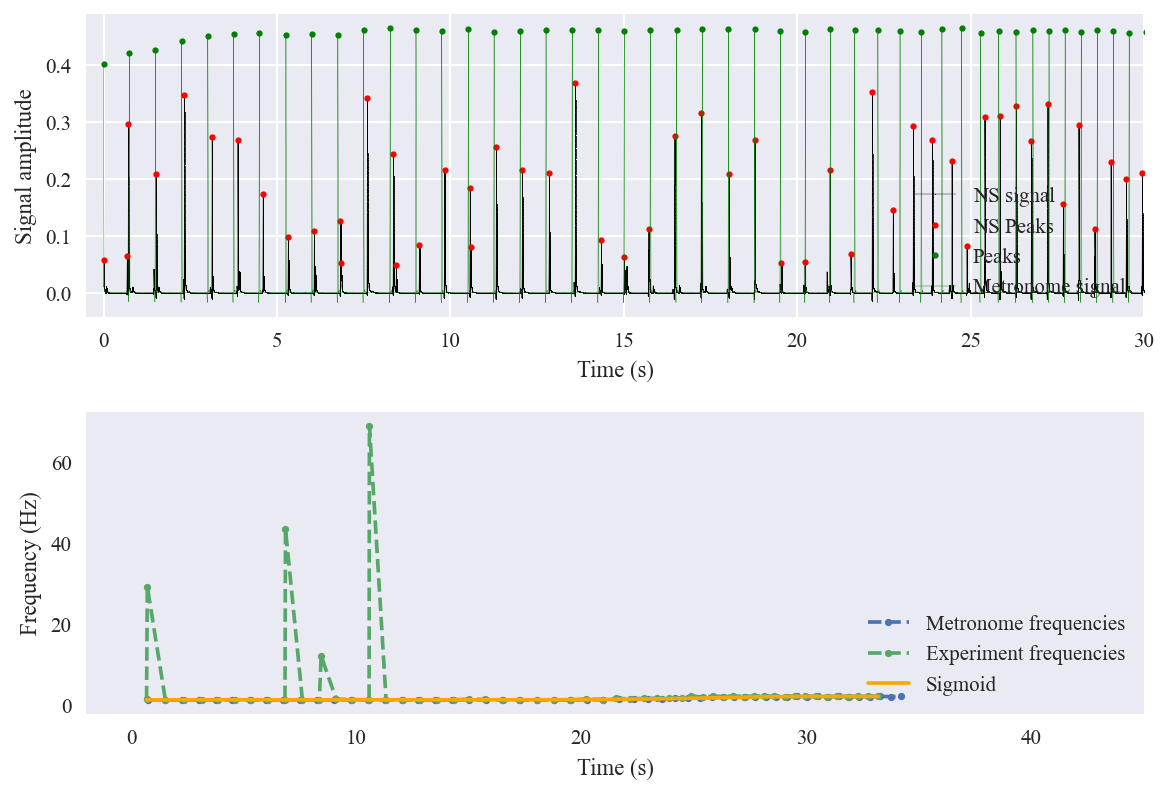

In [1118]:
sig_x = np.linspace(0, ft_ns_lm[-1], len(ft_ns_lm))
p_list = p_func(sig_x, threshold_l = 24, threshold_h = 48)
sig_y = 1 / interval_calc(80,130, p_list)

fig, ax = plt.subplots(2,1, dpi=150)

ax[0].plot(t_ns_lm, s_ns_lm, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='NS signal')
ax[0].plot(pt_ns_lm, p_ns_lm, color='red', ls='', marker='o', markersize=3, label='NS Peaks')
ax[0].plot(pt_met_lm, p_met_lm, color='green', ls='', marker='o', markersize=3, label='Peaks')
ax[0].plot(t_met_lm, s_met_lm, color='green', ls='-', linewidth = 0.2, label='Metronome signal')
ax[0].legend(loc='lower right')
ax[0].set_xlim(-0.5,30)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')

ax[1].plot(ft_met_lm, f_met_lm, '.--', label='Metronome frequencies')
ax[1].plot(ft_ns_lm, f_ns_lm, '.--', label='Experiment frequencies')
ax[1].plot(ft_ns_lm, sig_y, c='orange', label = 'Sigmoid')
ax[1].set_xlim(-2,45)
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].legend(loc='lower right')

fig.tight_layout()

### Fixing Gefion 3y data

_____

In [951]:
n9_lm = data_extract_lp('lydfiler/3y/lm_n9.wav', 
                               resolution=np.int16, 
                               cutoff_frequency=100, 
                               height_var=0.025,
                               prominence_var=0.05)

met_lm = data_extract_lp('lydfiler/metronomfiler/low_mid_inc_thres.wav', 
                                resolution=np.int32, 
                                cutoff_frequency=100, 
                                height_var=0.07,
                                prominence_var=0.3)


In [952]:
met_lm, n9_lm = synchro(met_lm, n9_lm)

t_met, s_met, pt_met, p_met, ft_met, f_met = met_lm
t_n9, s_n9, pt_n9, p_n9, ft_n9, f_n9 = n9_lm

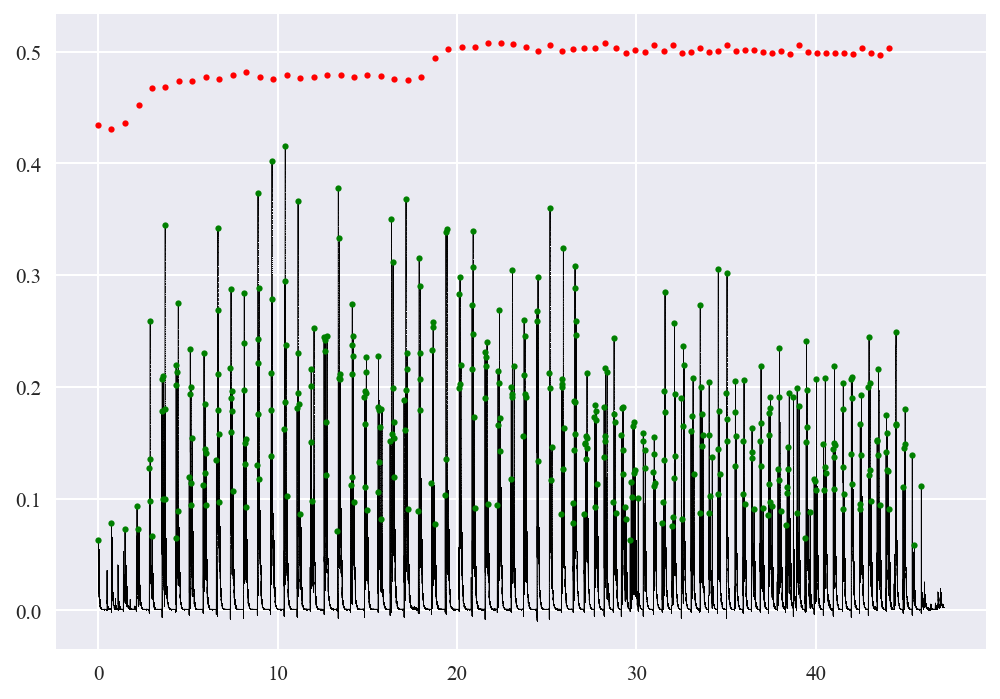

In [953]:
fig, ax = plt.subplots(dpi=150)

ax.plot(t_n9, s_n9, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='NS signal')
ax.plot(pt_met, p_met, color='red', ls='', marker='o', markersize=3, label='Metronome Peaks')
ax.plot(pt_n9, p_n9, color='green', ls='', marker='o', markersize=3, label='NS Peaks')
#ax.set_xlim(20, 35)

____

# Trying data analysis on data from Sigrids family

In [954]:
### OUTDATED!!!!! SETUP FOR LOADING ALL DATA FROM SIGRIDS FAMILY ###

filenames = ['Sigrids_familie/low_mid_fam', 'Sigrids_familie/low_high_fam',
             'Sigrids_familie/mid_low_fam', 'Sigrids_familie/mid_high_fam',
             'Sigrids_familie/high_low_fam', 'Sigrids_familie/high_mid_fam']


met_filenames = ['low_mid', 'low_high',
                 'mid_low', 'mid_high',
                 'high_low', 'high_mid']



fam_list = []
for i, name in enumerate(filenames):
    synced_data = final_data_lp_added(met_filenames[i], 
                                 name, 
                                 resolution=(np.int16, np.int16), 
                                 cutoff_frequency=(100, 100), 
                                 height=(0.05, 0.05), 
                                 prominence=(0.01, 0.01))
    
    fam_list.append(synced_data)

low = 80
mid = 130
high = 180

max_beats = 56
threshold_l = 24
threshold_h = 40

# 3x3 bpm matrix
bpm = np.array([[(low, low), (low, mid), (low, high)],
                [(mid, low), (mid, mid), (mid, high)],
                [(high, low), (high, mid), (high, high)]])
# set diag = 0
for i in range(3):
    bpm[i,i] = (0, 0)



In [955]:
# fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
# 
# 
# counter = 0
# for i in range(ax.shape[0]):
#     for j in range(ax.shape[1]):
#         if i != j:
# 
#             sig_x = np.linspace(0, fam_list[counter][3][-1], len(fam_list[counter][3]))
#             p_list = p_func(sig_x, threshold_l - 8, threshold_h - 8)
#             sig_y = 1 / interval_calc(*bpm[i,j], p_list)
# 
#             ax[i,j].errorbar(fam_list[counter][3], fam_list[counter][0], yerr=fam_list[counter][1], marker='.', ls='', elinewidth=0.5, markersize=5, capsize=1, capthick=0.5)
#             ax[i,j].plot(fam_list[counter][3], fam_list[counter][2], marker='.', ls='', color='red', alpha=0.5)
#             ax[i,j].set(xlabel = ('Time [s]'), ylabel = ('Frequency [Hz]'))
#             ax[i,j].plot(fam_list[counter][3], sig_y, ls='--', marker='', linewidth=0.8, color='k', alpha=1)
# 
#             counter += 1
#         else: 
#             ax[i,j].set_visible(False)
#         
# 
# fig.tight_layout()
# plt.show()


In [956]:
### Plotting signals with peaks ###


# fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
# ax = ax.flatten()
# 
# counter = 0
# for i in range(len(ax)):
#     if i % 4 != 0:
#     
#         ax[i].plot(fam_list[counter][4], fam_list[counter][5], marker='', ls='-', linewidth=0.5, color='k', alpha=0.5)
#         ax[i].plot(fam_list[counter][6], fam_list[counter][7], marker = 'o', markersize = 3, ls = '')
#         #ax[i].set(ylim=(0.8, 5), xlabel = ('Time [s]'), ylabel = ('Frequency [Hz]'))
# 
#         counter += 1
#     else: 
#         ax[i].set_visible(False)
# 
# fig.tight_layout()



In [957]:
mh_tuple = final_data_lp_added('mid_high', 
                   'Sigrids_familie/mid_high_fam', 
                   resolution=(np.int16, np.int16),
                   prominence=(0.01, 0.01))


In [958]:
### Checking peaks and signal for a single file ###

# mh_pt_met = mh_tuple[8]
# bin_edges = (mh_pt_met[:-1] + mh_pt_met[1:])/2
# bin_edges = np.pad(bin_edges, (1,1), 'constant', constant_values=((bin_edges[1] - 2 * bin_edges[0]), 2 * bin_edges[-1] - bin_edges[-2]))
# zeroes = np.zeros(len(bin_edges))
# 
# fig, ax = plt.subplots(figsize=(10,8), dpi=200)
# ax.plot(fam_list[3][4], fam_list[3][5], marker='', ls='-', linewidth=0.5, color='k', alpha=0.5)
# ax.plot(fam_list[3][6], fam_list[3][7], marker = 'o', markersize = 3, ls = '')
# # Plot metronone peak times
# ax.plot(mh_pt_met, mh_tuple[9], marker='o', markersize=3, ls='')
# ax.vlines(bin_edges, 0, 0.12, ls='--', color='orange', alpha=0.5)




In [959]:
# fam_met_dev = []
# for i in range(len(fam_list)):
#     fam_met_dev.append(np.abs(fam_list[i][2] - fam_list[i][0]))
# 
# fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
# ax = ax.flatten()
# 
# counter = 0
# 
# for i in range(len(ax)):
#     if i % 4 != 0:
#         ax[i].plot(fam_list[counter][3], fam_met_dev[counter], marker='.', ls='')
#         ax[i].set(xlabel = ('Time [s]'), ylabel = (r'$\Delta f$ [Hz]'))
#         counter += 1
#     else: 
#         ax[i].set_visible(False)
# 
# fig.tight_layout()


____

## Analyse af Gefiondata med $prominence = 0.07$ 

In [960]:
gefion_3y_extensions = ['3y/', 9]
resolution = (np.int16, np.int16)
cutoff_freq = (100, 100)

# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]

gefion_3y_exp_data = experiment_data_ext(gefion_3y_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# avg_freq, freq_err, f_met, x, t_exp, s_exp, pt_exp, p_exp, pt_met, p_met


(20.0, 25.0)

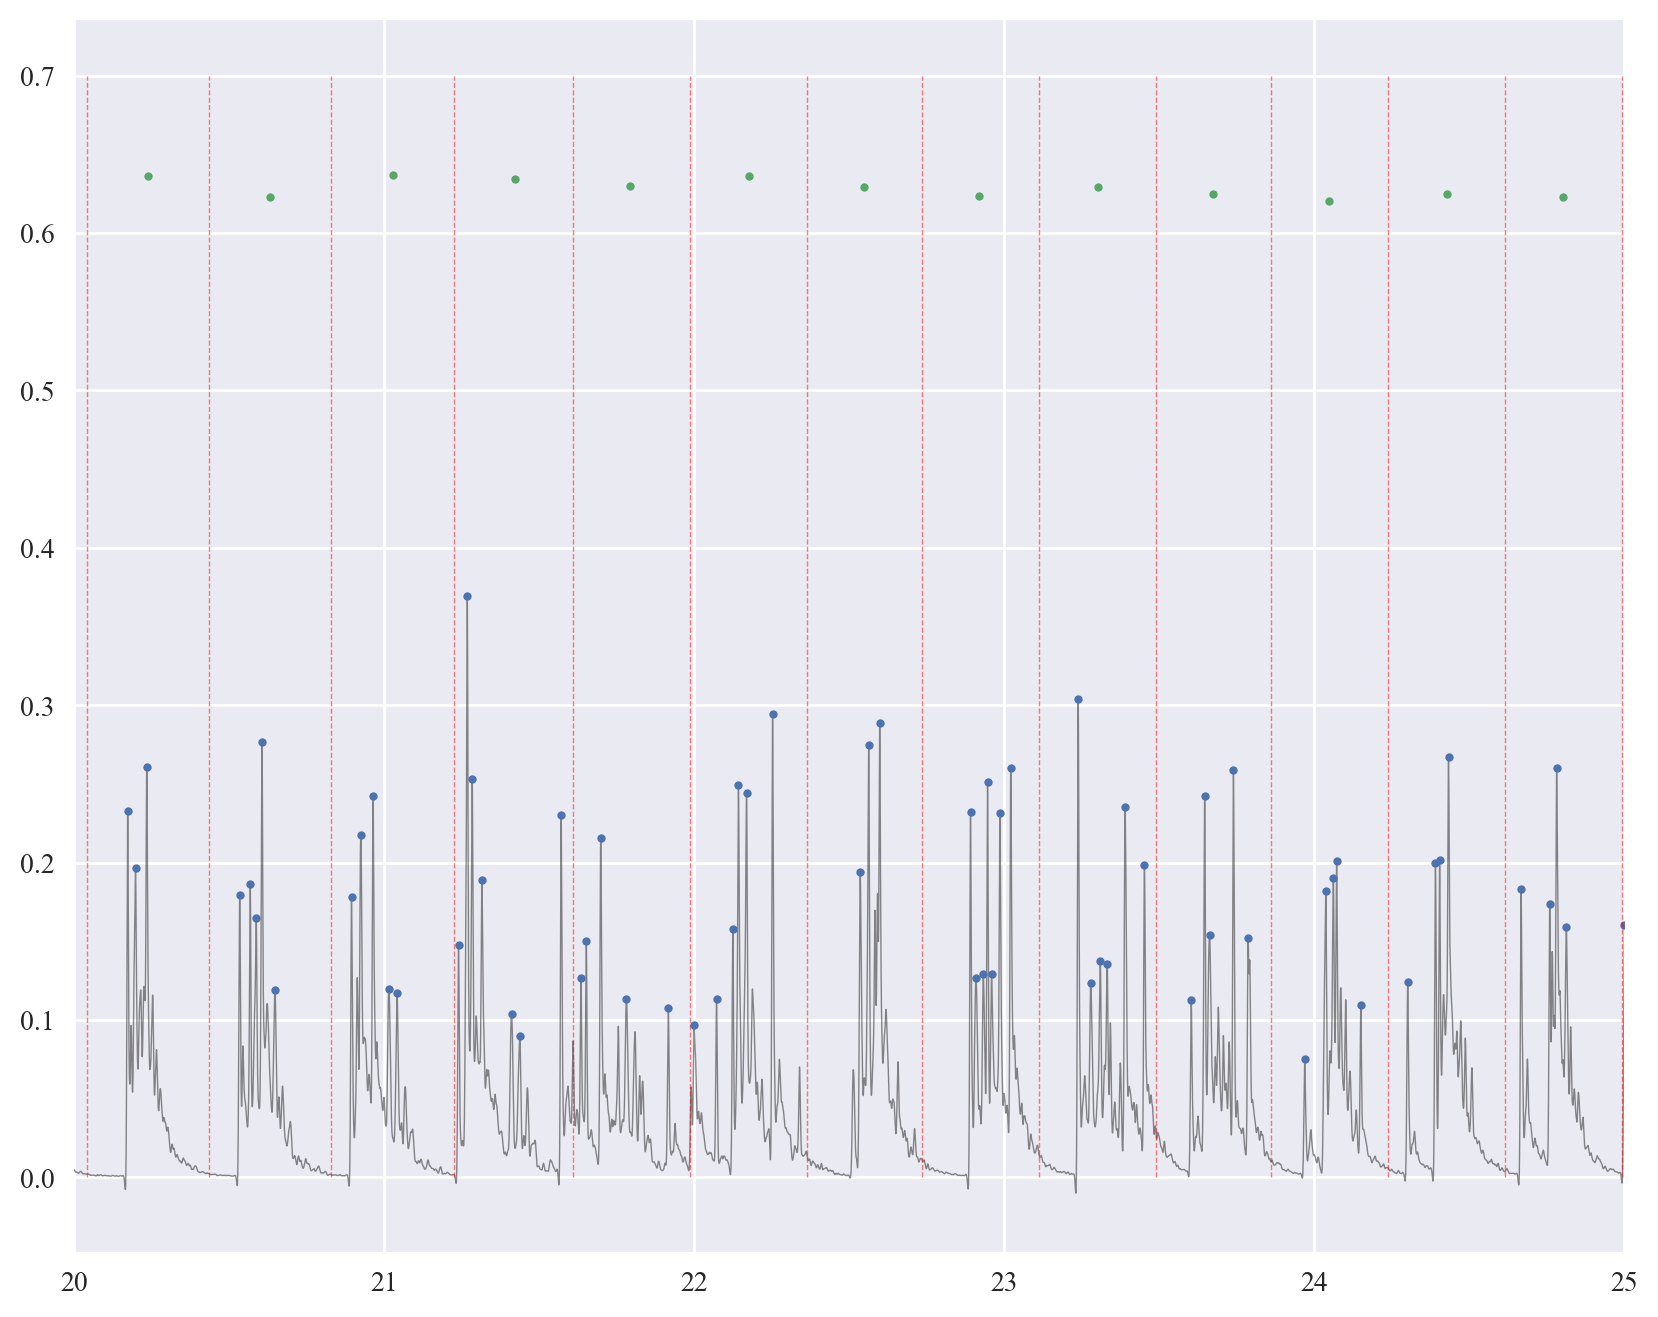

In [961]:
# Plot index 1 (LH) of the experiment data
fig, ax = plt.subplots(figsize=(10,8), dpi=200)
ax.plot(gefion_3y_exp_data[3][4], gefion_3y_exp_data[3][5], marker='', ls='-', linewidth=0.5, color='k', alpha=0.5)
ax.plot(gefion_3y_exp_data[3][6], gefion_3y_exp_data[3][7], marker = 'o', markersize = 3, ls = '')
# Plot metronone peak times
ax.plot(gefion_3y_exp_data[3][8], gefion_3y_exp_data[3][9], marker='o', markersize=3, ls='')

mh_pt_met = gefion_3y_exp_data[3][8]
bin_edges = (mh_pt_met[:-1] + mh_pt_met[1:])/2
start_diff = bin_edges[1] - bin_edges[0]
end_diff = bin_edges[-1] - bin_edges[-2]
bin_edges = np.pad(bin_edges, (1,1), 'constant', constant_values=(bin_edges[0] - start_diff, bin_edges[-1] + end_diff))

ax.vlines(bin_edges, 0, 0.7, ls='--', color='red', alpha=0.5, linewidth=0.5)
ax.set_xlim(20, 25)


In [962]:
#fig, ax = exp_data_plot_func(gefion_3y_exp_data)
#fig.savefig('3y_gefion_n9.png')

In [963]:
dev_dict = {}
dev_dict['dev_tuple_3y_n9'] = deviation_func(gefion_3y_exp_data, 24, 48)
# fig_dev, ax_dev = deviation_plot(gefion_3y_exp_data, dev_dict['dev_tuple_3y_n9'], )
# fig_dev.savefig('3y_gefion_n9_dev.png')

#fig_time_dev, ax_time_dev = time_deviation_plot(gefion_3y_exp_data, dev_dict['dev_tuple_3y_n9'])

# WIDTH OF THE SIGNAL

In [964]:
met_mid_low_us = read_wave('lydfiler/metronomfiler/mid_low_inc_thres.wav', resolution=np.int16)

met_mid_low_filt = lp_filter(met_mid_low_us[0], cutoff_frequency=100)

# fig, ax = plt.subplots(1,1, dpi=100, figsize=(10,8))
# ax.set(xlim=(9.8,9.9))
# ax.plot(met_mid_low_us[2], met_mid_low_us[0], color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Unfiltered signal')
# ax.plot(met_mid_low_us[2], met_mid_low_filt, color='red', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Filtered signal')


______

In [1088]:
gefion_3p_n7_1_extensions = ['3p/n7_1/', 7]
resolution = (np.int16, np.int16)
cutoff_freq = (100, 100)

# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]

gefion_3p_n7_1_data = experiment_data_ext(gefion_3p_n7_1_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
# fig, ax = exp_data_plot_func(gefion_3p_n7_1_data)

64 64
64 64
64 64
64 64
64 64
64 64


In [1089]:
dev_dict['dev_tuple_3p_n7_1'] = deviation_func(gefion_3p_n7_1_data, 24, 48)
# fig_dev, ax_dev = deviation_plot(gefion_3p_n7_1_data, dev_dict['dev_tuple_3p_n7_1'])
# fig_time_dev_n7_1, ax_time_dev_n7_1 = time_deviation_plot(gefion_3p_n7_1_data, dev_dict['dev_tuple_3p_n7_1'])

64 64
64 64
64 64
64 64
64 64
64 64


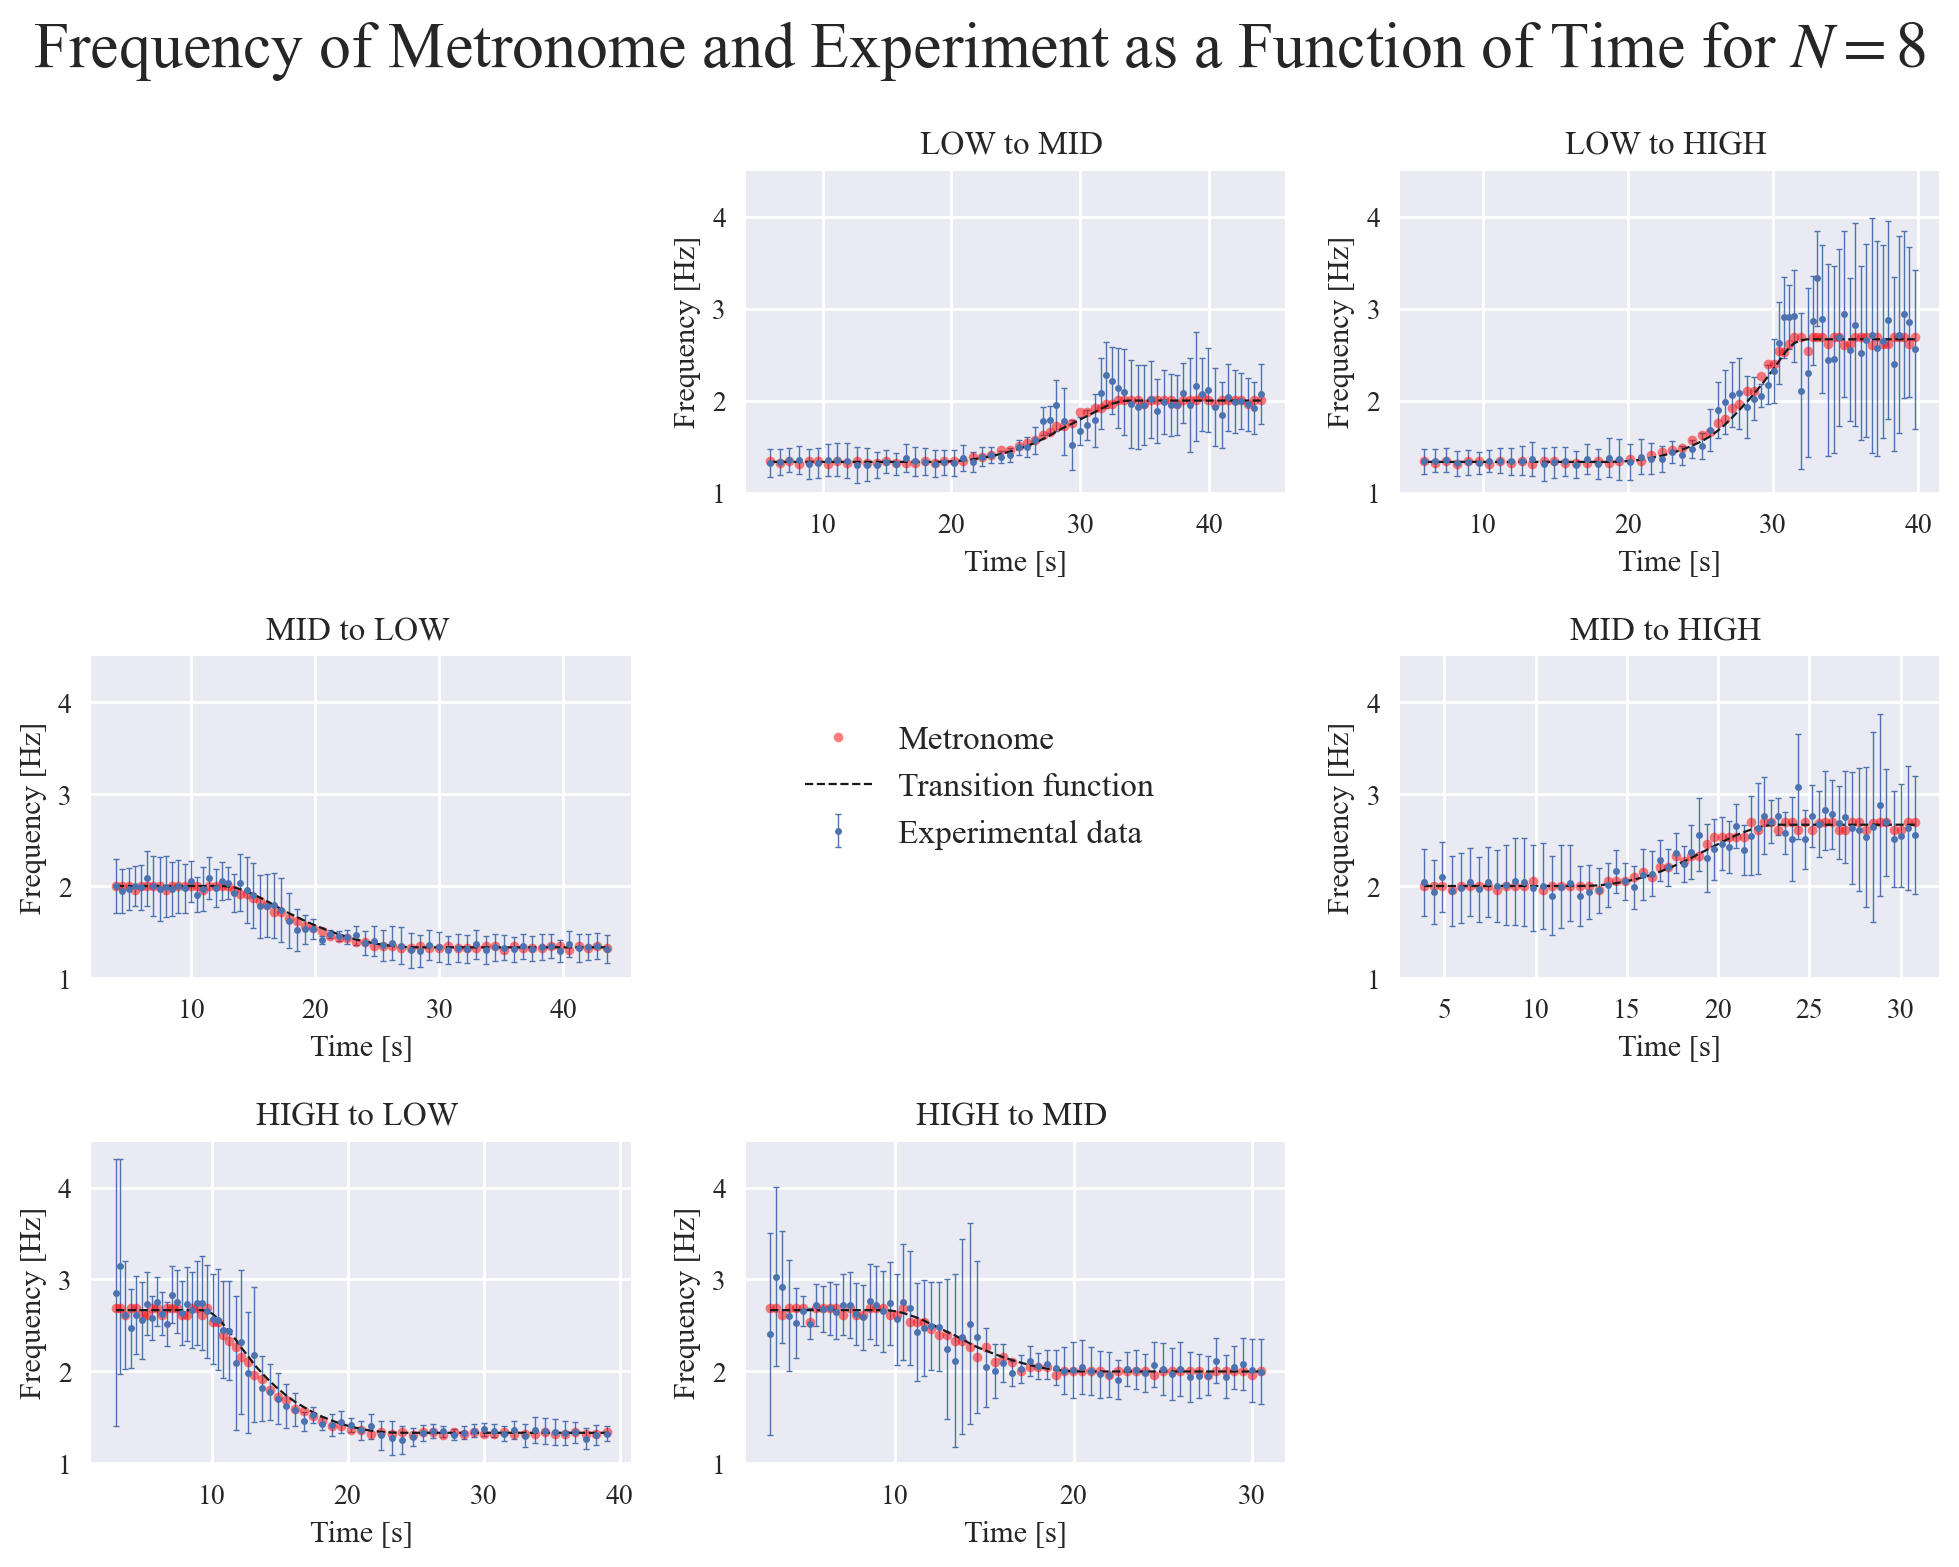

In [1090]:
gefion_3p_n7_2_extensions = ['3p/n7_2/', 7]
resolution = (np.int16, np.int16)
cutoff_freq = (100, 100)

gefion_3p_n7_2_data = experiment_data_ext(gefion_3p_n7_2_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
fig, ax = exp_data_plot_func(gefion_3p_n7_2_data)
fig.suptitle(r'Frequency of Metronome and Experiment as a Function of Time for $N = 8$', fontsize=23)
fig.tight_layout()
#fig.savefig('figurer/rapport/frekvens_forsøg.png')

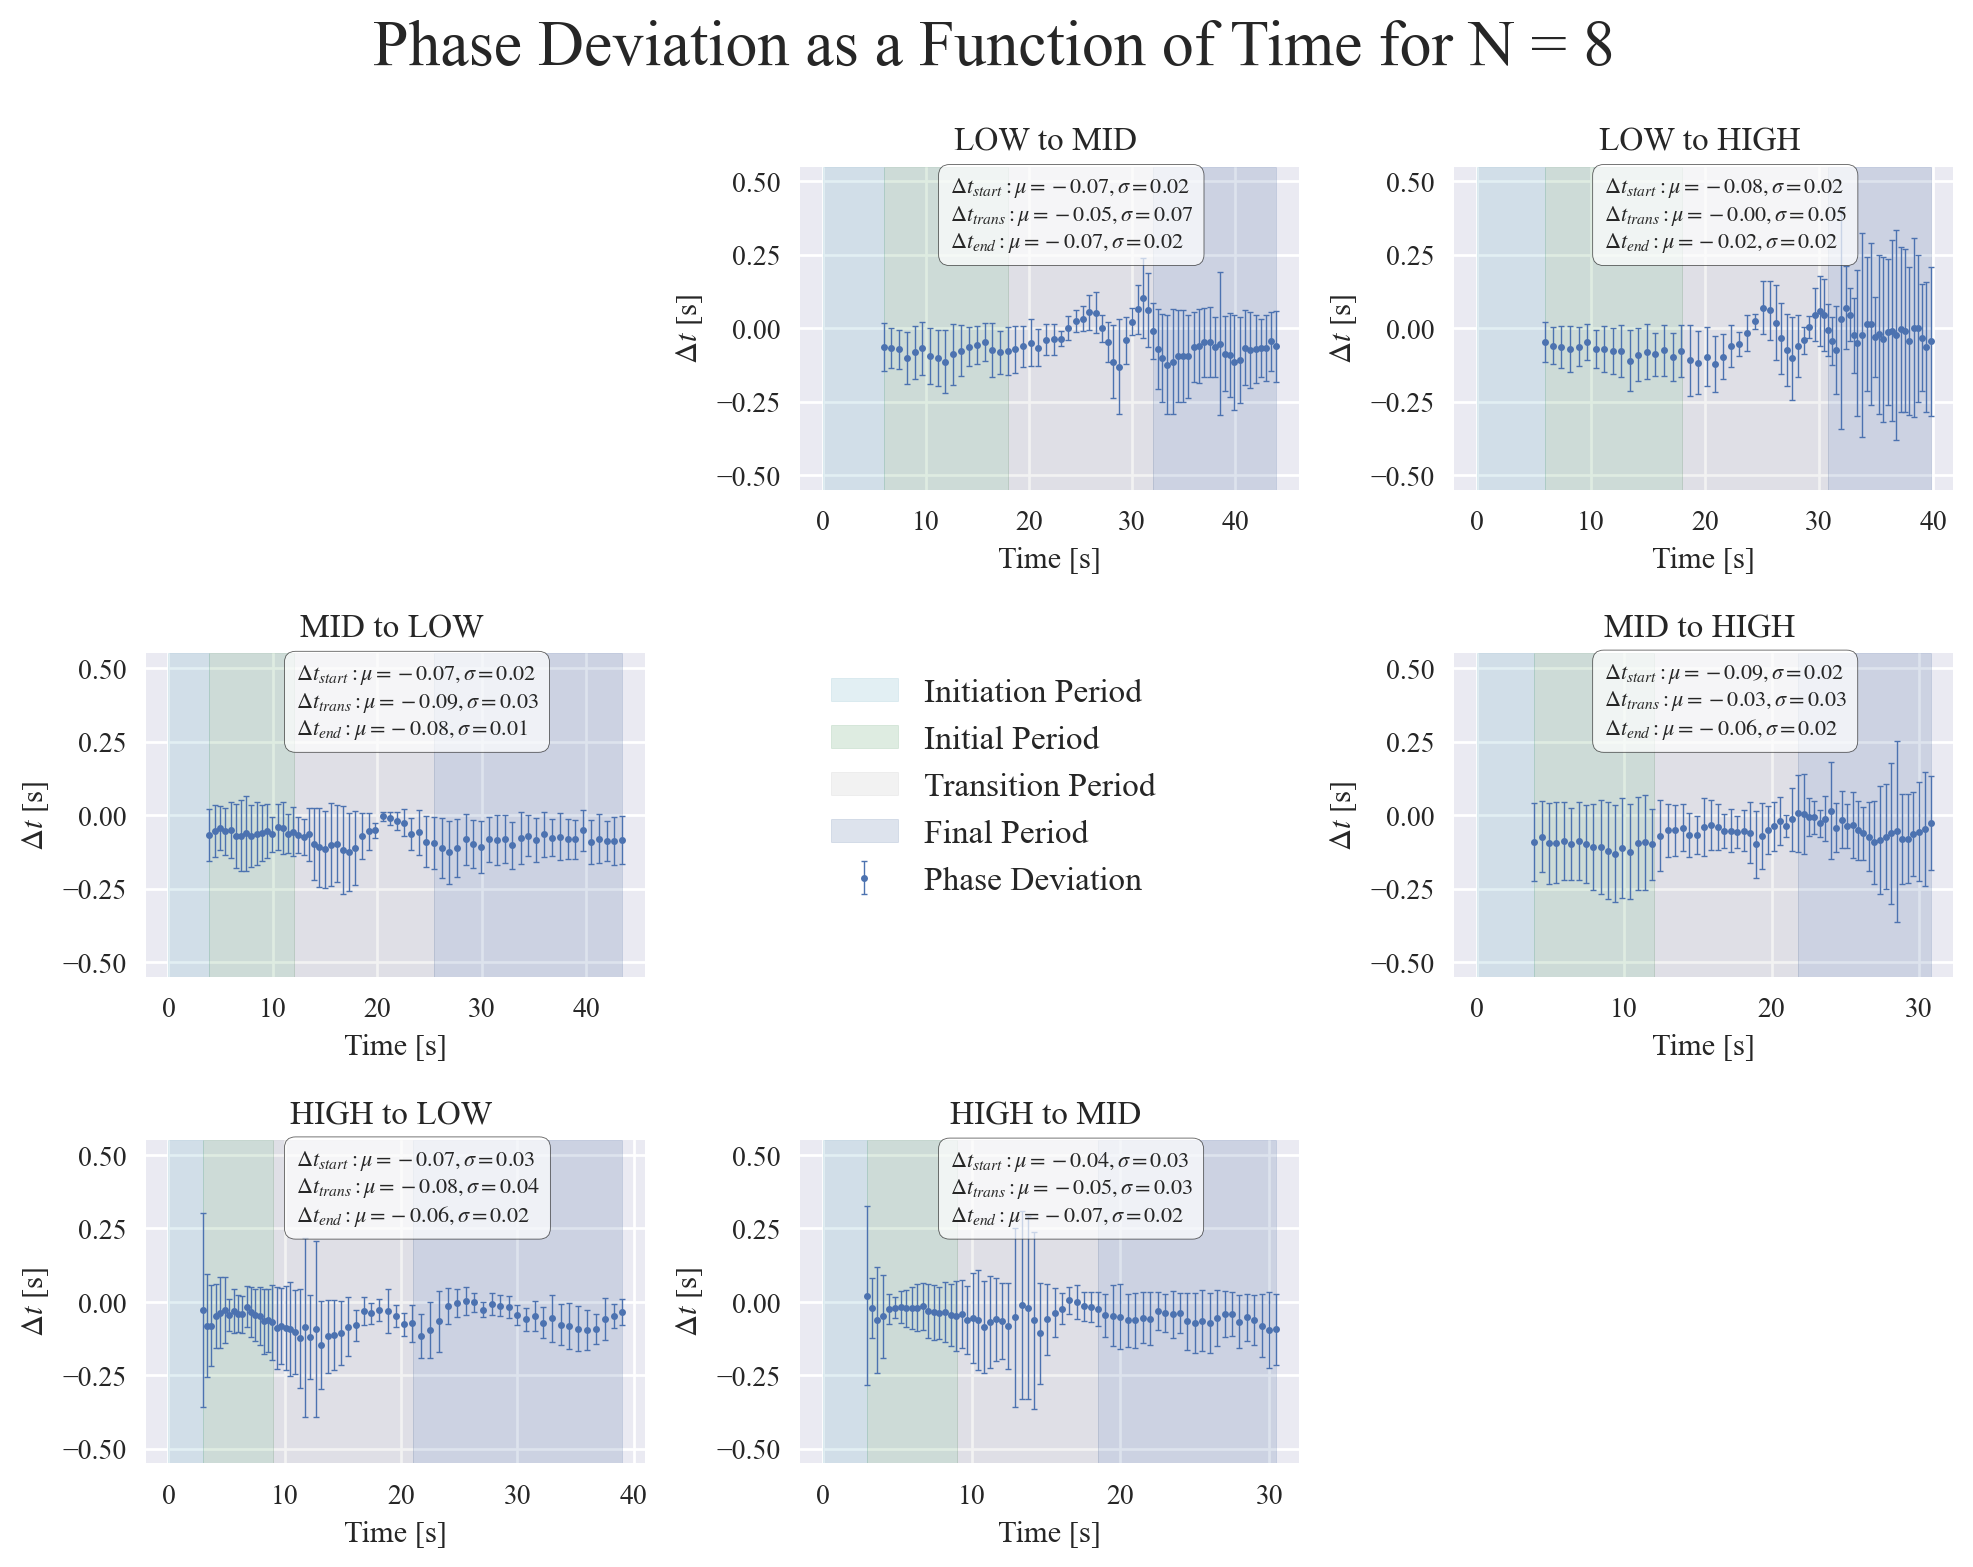

In [1130]:
dev_dict['dev_tuple_3p_n8_2'] = deviation_func(gefion_3p_n7_2_data, 24, 48)

# fig_dev, ax_dev = deviation_plot(gefion_3p_n7_2_data, dev_dict['dev_tuple_3p_n8_2'])
# fig_dev.suptitle('Gefion 3.p, n=7, andet forsøg')
fig_time_dev_n7_2, ax_time_dev_n7_2 = time_deviation_plot(gefion_3p_n7_2_data, dev_dict['dev_tuple_3p_n8_2'])
fig_time_dev_n7_2.suptitle('Phase Deviation as a Function of Time for N = 8', fontsize=23)
fig_time_dev_n7_2.tight_layout()
fig_time_dev_n7_2.savefig('figurer/rapport/timedev_vs_time.png')

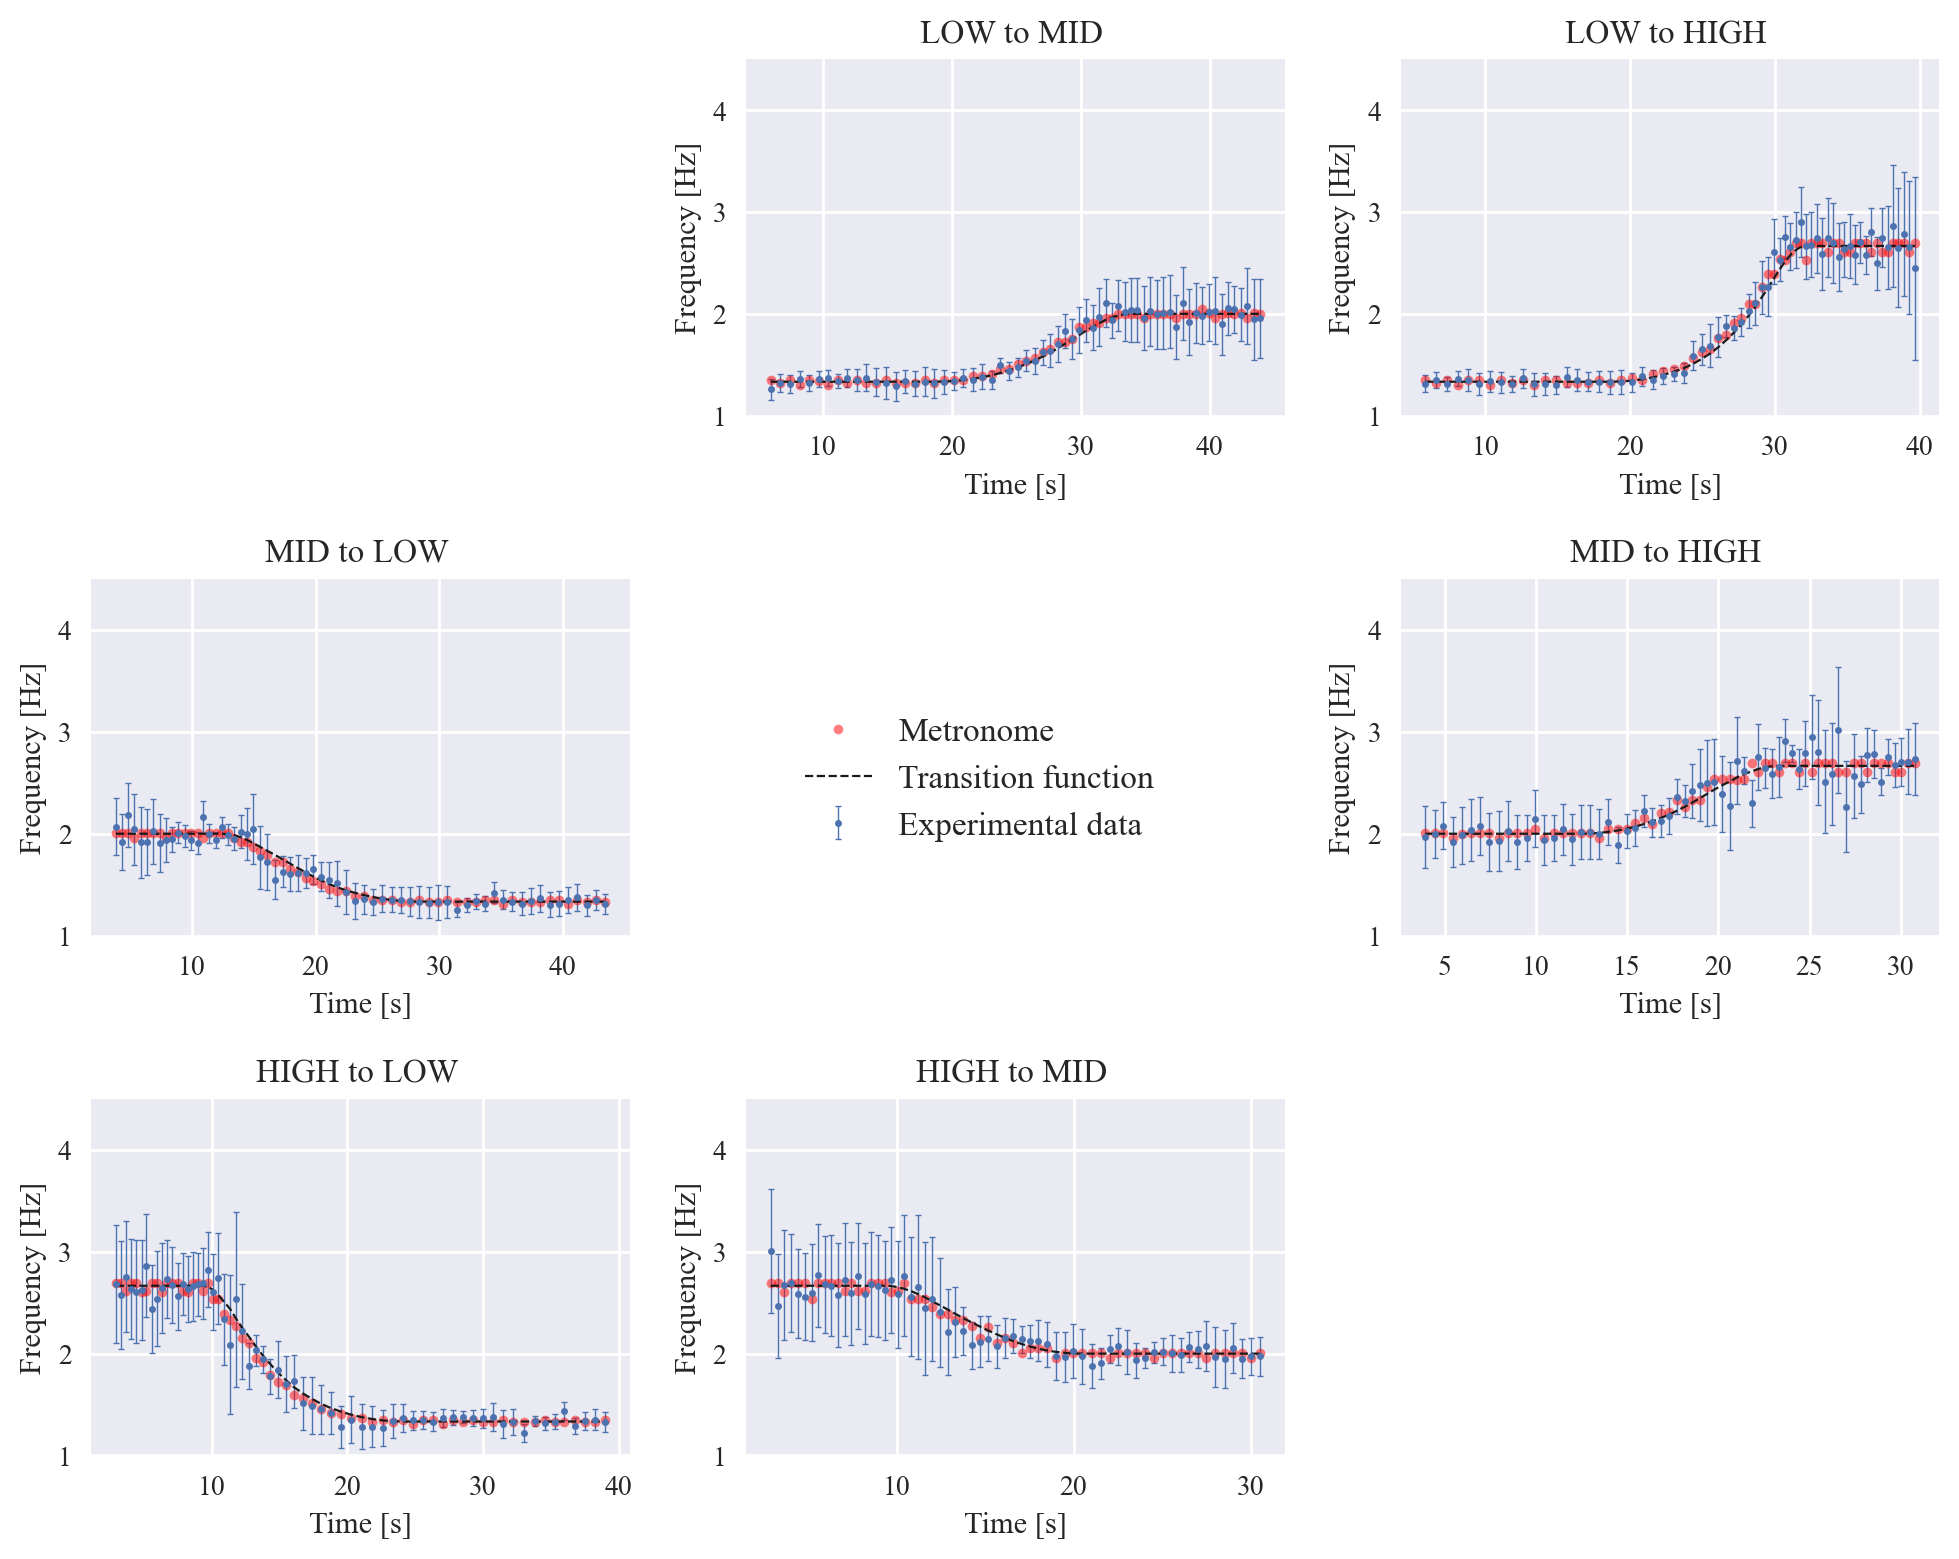

In [969]:
gefion_3p_n11_extensions = ['3p/n11/', 11]
resolution = (np.int16, np.int16)
cutoff_freq = (100, 100)

gefion_3p_n11_data = experiment_data_ext(gefion_3p_n11_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

fig, ax = exp_data_plot_func(gefion_3p_n11_data)




In [970]:
dev_dict['dev_tuple_3p_n11'] = deviation_func(gefion_3p_n11_data, 24, 48)

# fig_dev, ax_dev = deviation_plot(gefion_3p_n11_data, dev_dict['dev_tuple_3p_n11'])
#fig_time_dev_n11, ax_time_dev_n11 = time_deviation_plot(gefion_3p_n11_data, dev_dict['dev_tuple_3p_n11'])

In [971]:
gefion_n22_extensions = ['n22/', 22]
gefion_n22_data = experiment_data_ext(gefion_n22_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n22, ax_n22 = exp_data_plot_func(gefion_n22_data)

In [972]:
dev_dict['dev_tuple_n22'] = deviation_func(gefion_n22_data, 24, 48)

# fig_dev_n22, ax_dev_n22 = deviation_plot(gefion_n22_data, dev_dict['dev_tuple_n22'])
# fig_time_dev_n22, ax_time_dev_22 = time_deviation_plot(gefion_n22_data, dev_dict['dev_tuple_n22'])

In [973]:
gefion_n25_extensions = ['n25/', 25]
gefion_n25_data = experiment_data_ext(gefion_n25_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n25, ax_n25 = exp_data_plot_func(gefion_n25_data)

In [974]:
dev_dict['dev_tuple_n25'] = deviation_func(gefion_n25_data, 24, 48)

# fig_dev_n25, ax_dev_n25 = deviation_plot(gefion_n25_data, dev_dict['dev_tuple_n25'])
# fig_time_dev_n25, ax_time_dev_25 = time_deviation_plot(gefion_n25_data, dev_dict['dev_tuple_n25'])

_____

## Load af efterskoledata med $prominence = 0.01$ 


In [975]:
# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Height and prominence for experiment
height_exp = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
prom_exp = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

In [976]:
efterskole_n5_extensions = ['efterskole/', 5]
efterskole_n5_data = experiment_data_ext(efterskole_n5_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n5, ax_n5 = exp_data_plot_func(efterskole_n5_data)

In [977]:
# dev_dict['dev_tuble_n5'] = deviation_func(efterskole_n5_data, 24, 48)
# fig_dev_n5, ax_dev_n5 = deviation_plot(efterskole_n5_data, dev_dict['dev_tuble_n5'])
# fig_time_dev_n5, ax_time_dev_5 = time_deviation_plot(efterskole_n5_data, dev_dict['dev_tuble_n5'])

_ _ _ _ _ 

### Resolving issues

In [978]:
efterskole_ml = data_extract_lp('lydfiler/efterskole/ml_n5.wav', 
                               resolution=np.int16, 
                               cutoff_frequency=100, 
                               height_var=0.01,
                               prominence_var=0.02)

met_efterskole_ml = data_extract_lp('lydfiler/metronomfiler/mid_low_inc_thres.wav', 
                                resolution=np.int32, 
                                cutoff_frequency=100, 
                                height_var=0.07,
                                prominence_var=0.3)


met_efterskole_ml, efterskole_ml = synchro(met_efterskole_ml, efterskole_ml)

t_met, s_met, pt_met, p_met, ft_met, f_met = met_efterskole_ml
t_efterskole, s_efterskole, pt_efterskole, p_efterskole, ft_efterskole, f_efterskole = efterskole_ml

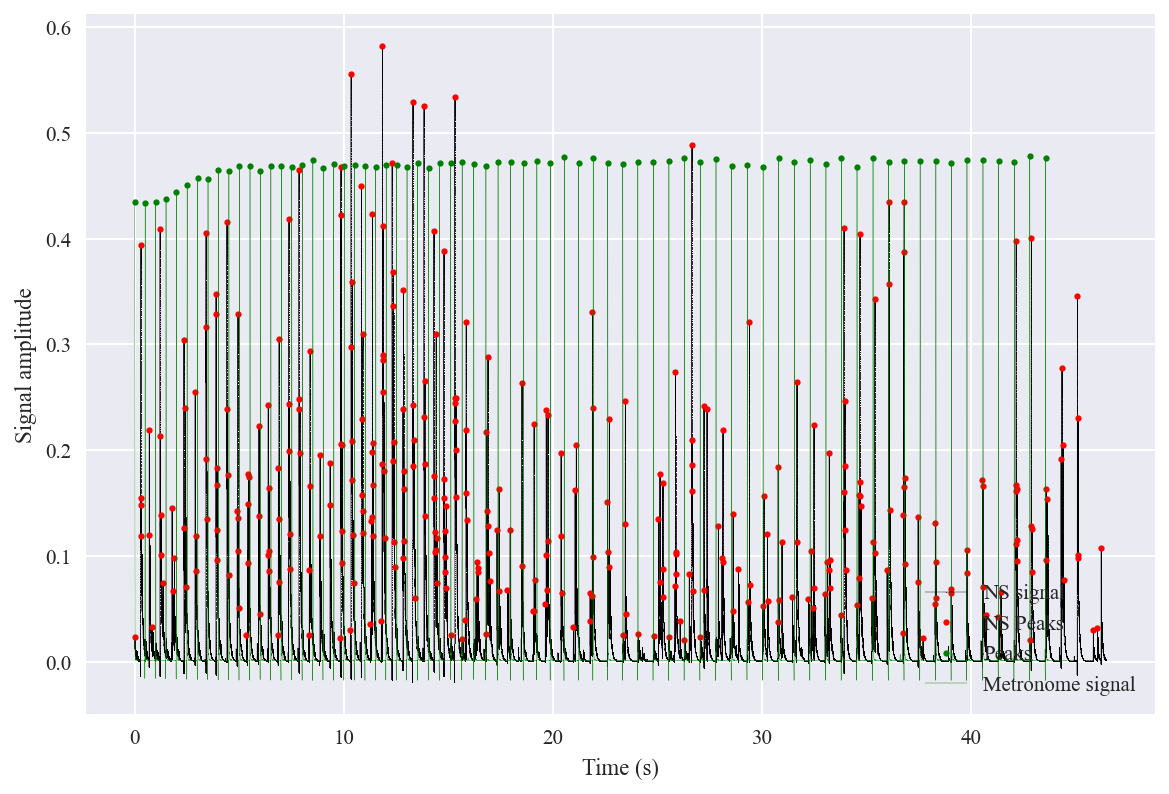

In [979]:
fig, ax = plt.subplots(dpi=150)

ax.plot(t_efterskole, s_efterskole, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='NS signal')
ax.plot(pt_efterskole, p_efterskole, color='red', ls='', marker='o', markersize=3, label='NS Peaks')
ax.plot(pt_met, p_met, color='green', ls='', marker='o', markersize=3, label='Peaks')
ax.plot(t_met, s_met, color='green', ls='-', linewidth = 0.2, label='Metronome signal')
ax.legend(loc='lower right')
#ax.set_xlim(0, 2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
#ax.set_xlim(30,35)

fig.tight_layout()

____

## Fysikvenner clapping

In [980]:
# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

In [981]:
n4_extensions = ['fysikvenner/', 4]
n4_data = experiment_data_ext(n4_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
#fig_n4, ax_n4 = exp_data_plot_func(n4_data)

In [982]:
dev_dict['dev_tuple_n4'] = deviation_func(n4_data, 24, 48)
# fig_dev_n4, ax_dev_n4 = deviation_plot(n4_data, dev_dict['dev_tuple_n4'])
# fig_time_dev_n4, ax_time_dev_4 = time_deviation_plot(n4_data, dev_dict['dev_tuple_n4'])

In [983]:
# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]

In [984]:
n6_extensions = ['andenårs/', 6]
n6_data = experiment_data_ext(n6_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
# fig_n6, ax_n6 = exp_data_plot_func(n6_data)

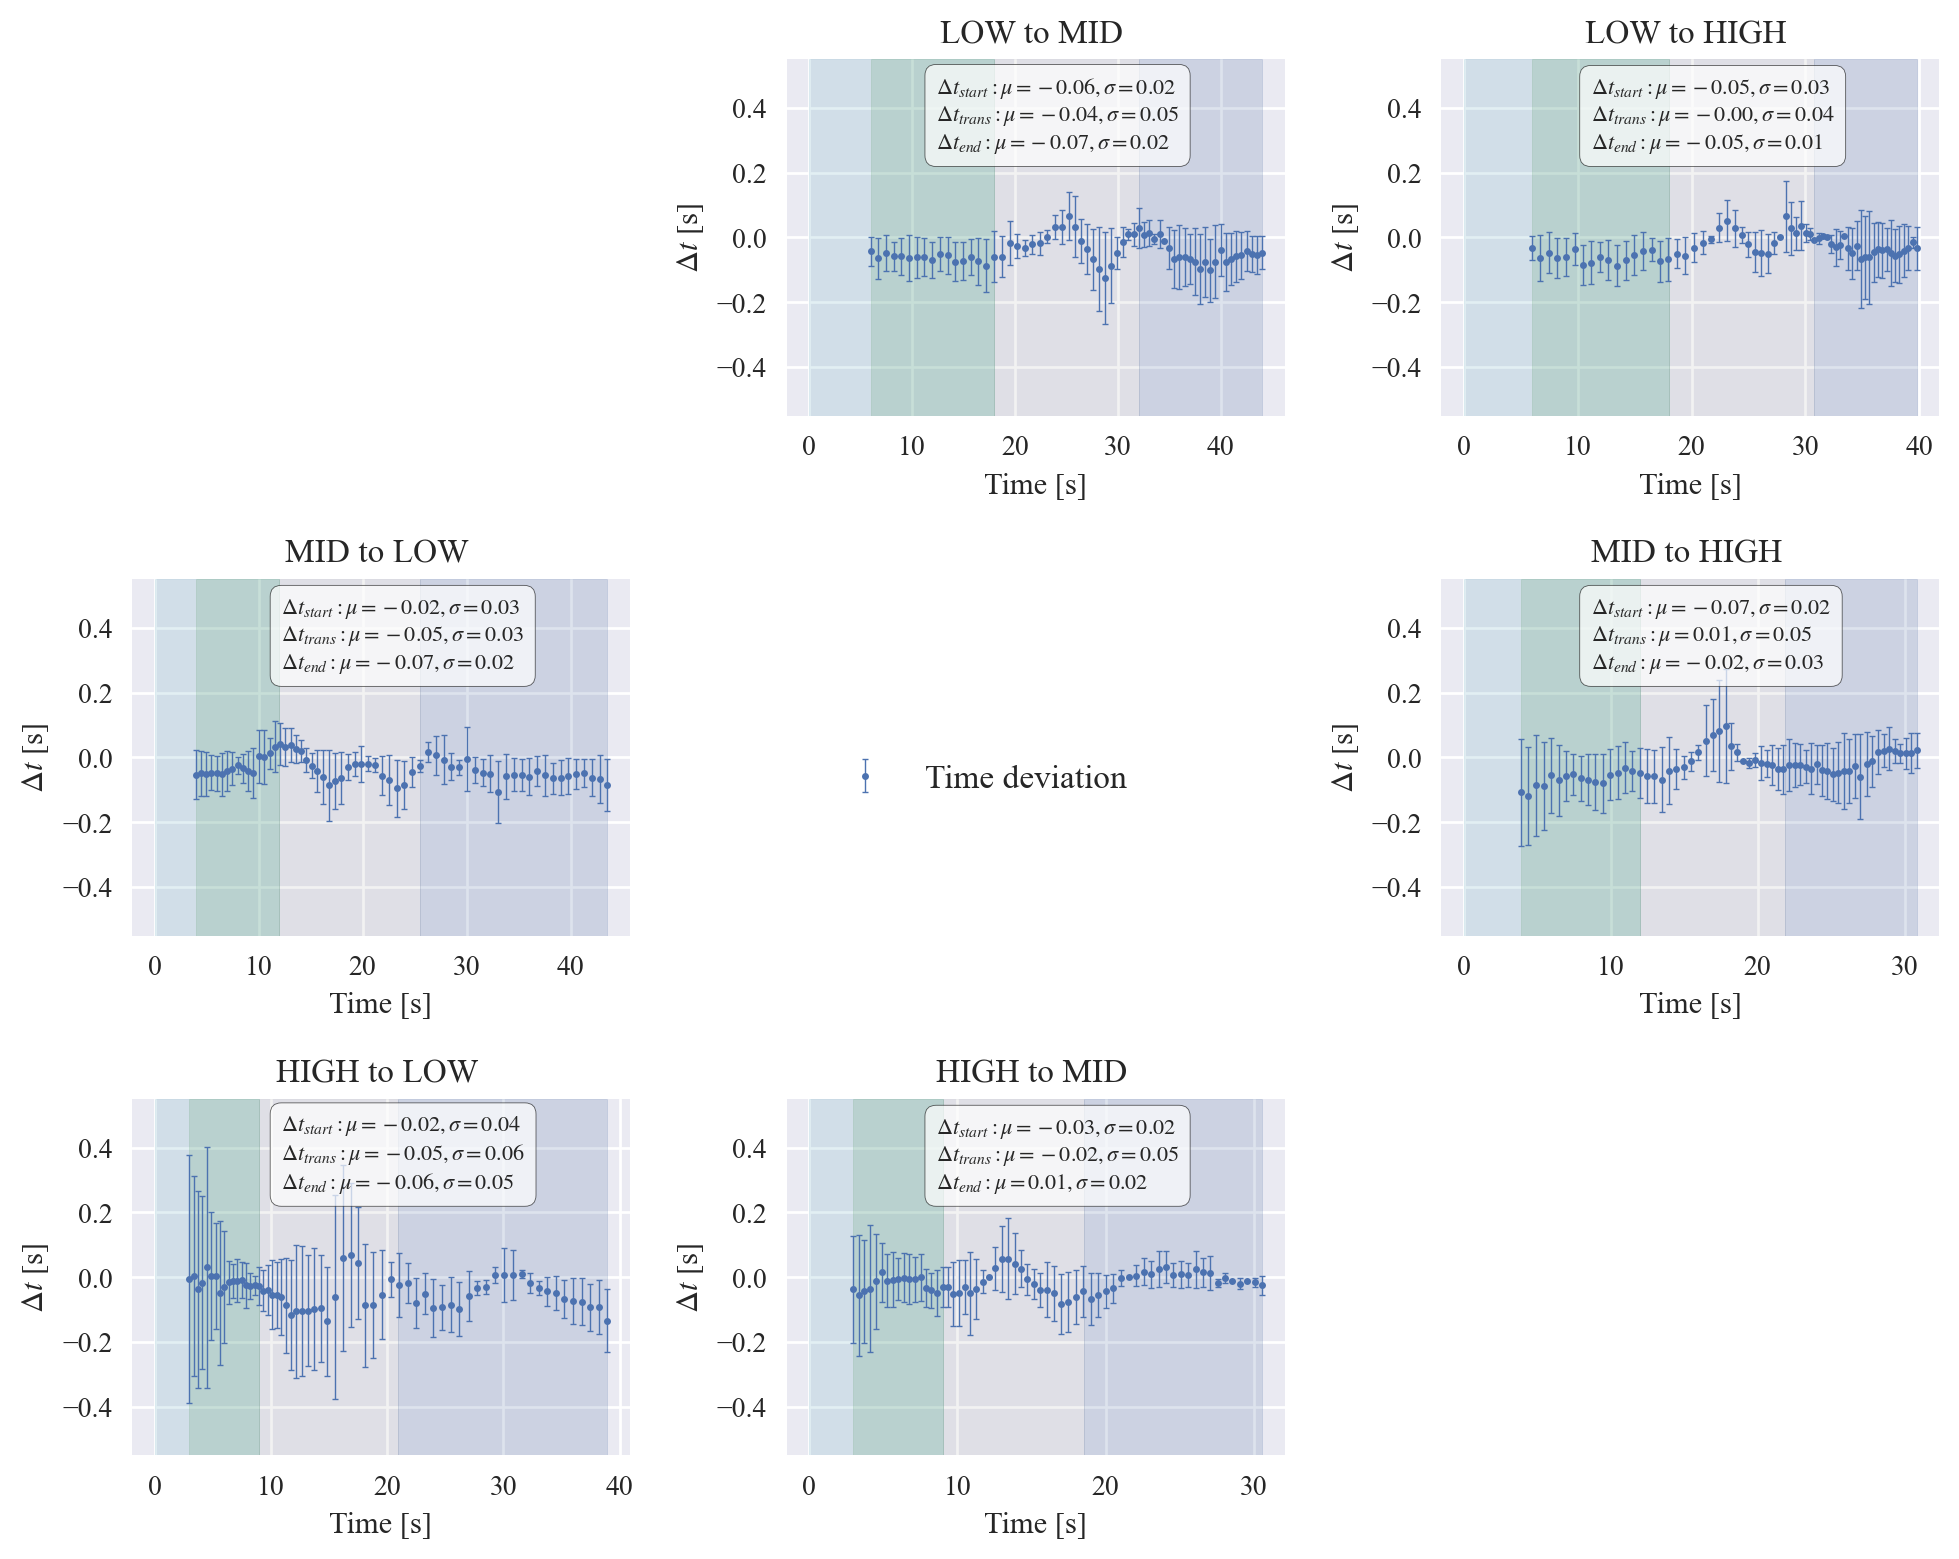

In [1109]:
dev_dict['dev_tuple_n6'] = deviation_func(n6_data, 24, 48)
# fig_dev_n6, ax_dev_n6 = deviation_plot(n6_data, dev_dict['dev_tuple_n6'])
fig_time_dev_n6, ax_time_dev_6 = time_deviation_plot(n6_data, dev_dict['dev_tuple_n6'])

In [986]:
n16_extensions = ['mekrel/', 16]

# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]


n16_data = experiment_data_ext(n16_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n16, ax_n16 = exp_data_plot_func(n16_data)

In [987]:
dev_dict['dev_tuple_n16'] = deviation_func(n16_data, 24, 48)
#fig_time_dev_n16, ax_time_dev_16 = time_deviation_plot(n16_data, dev_dict['dev_tuple_n16'])

In [988]:
# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]

In [989]:
n44_extensions = ['n44/', 44]
n44_data = experiment_data_ext(n44_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n44, ax_n44 = exp_data_plot_func(n44_data)

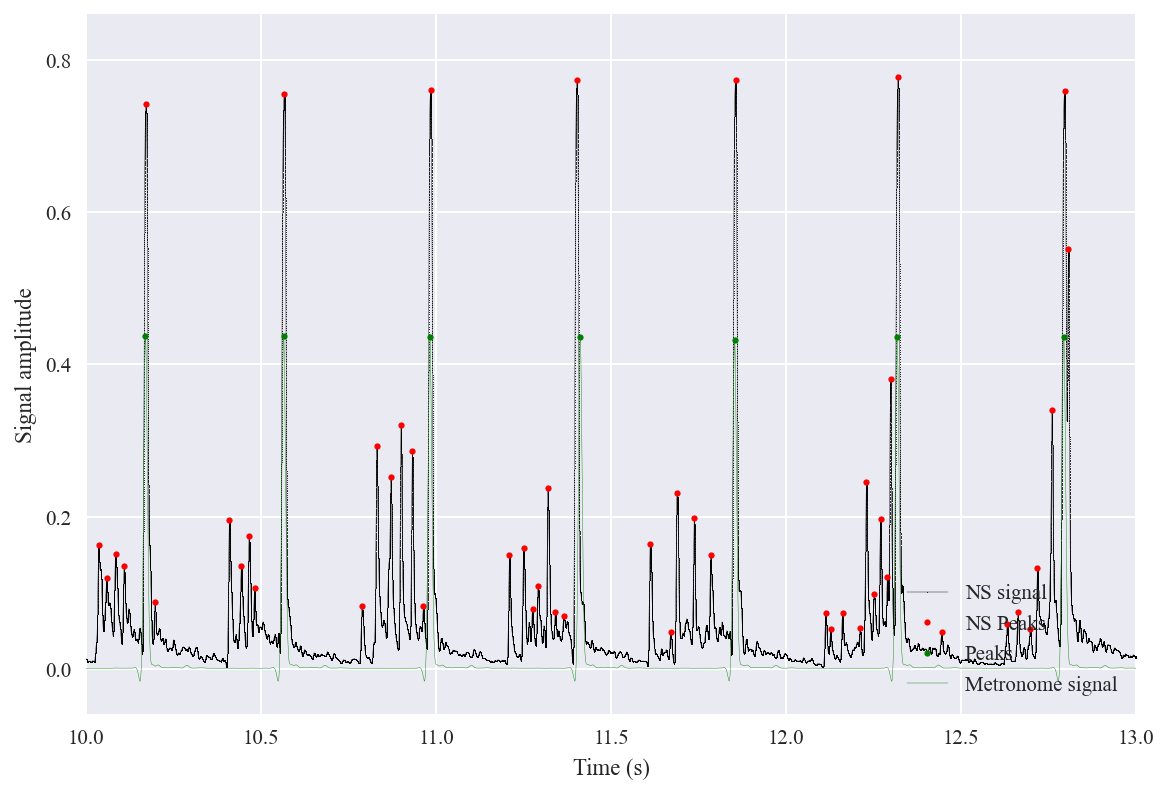

In [990]:
n44_hl = data_extract_lp('lydfiler/n44/hl_n44.wav',
                                 resolution=np.int16, 
                                 cutoff_frequency=100, 
                                 height_var=0.025,
                                 prominence_var=0.03)

met_n44_hl = data_extract_lp('lydfiler/metronomfiler/high_low_inc_thres.wav',
                                    resolution=np.int32, 
                                    cutoff_frequency=100, 
                                    height_var=0.07,
                                    prominence_var=0.3)

met_n44_hl, n44_hl = synchro(met_n44_hl, n44_hl)

t_met, s_met, pt_met, p_met, ft_met, f_met = met_n44_hl

t_n44, s_n44, pt_n44, p_n44, ft_n44, f_n44 = n44_hl

fig, ax = plt.subplots(dpi=150)

ax.plot(t_n44, s_n44, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='NS signal')
ax.plot(pt_n44, p_n44, color='red', ls='', marker='o', markersize=3, label='NS Peaks')
ax.plot(pt_met, p_met, color='green', ls='', marker='o', markersize=3, label='Peaks')
ax.plot(t_met, s_met, color='green', ls='-', linewidth = 0.2, label='Metronome signal')
ax.legend(loc='lower right')
#ax.set_xlim(0, 2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
ax.set_xlim(10,13)

fig.tight_layout()


In [991]:
dev_dict['dev_tuple_n44'] = deviation_func(n44_data, 24, 48)

In [992]:
# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.04, 0.04, 0.04, 0.04, 0.04, 0.04]

In [993]:
n28_extensions = ['cg/', 28]
n28_data = experiment_data_ext(n28_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

#fig_n28, ax_n28 = exp_data_plot_func(n28_data)

In [994]:
dev_dict['dev_tuple_n28'] = deviation_func(n28_data, 24, 48)

In [995]:
n27_extensions = ['n27/', 27]
n27_data = experiment_data_ext(n27_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
#fig_n27, ax_n27 = exp_data_plot_func(n27_data)

In [996]:
dev_dict['dev_tuple_n27'] = deviation_func(n27_data, 24, 48)
#fig_time_dev_n27, ax_time_dev_27 = time_deviation_plot(n27_data, dev_dict['dev_tuple_n27'])

In [1136]:
def dev_n_plot(dev_dict):
    n_list = []
    dev_start_list = [[] for i in range(6)]
    dev_trans_list = [[] for i in range(6)]
    dev_end_list = [[] for i in range(6)]

    for key in dev_dict.keys():
        regex = re.compile(r'n[0-9]+')
        match = regex.findall(key)
        n = int(match[0][1:])
        n_list.append(n)

        for i in range(6):
            dev_start_list[i].append(dev_dict[key][1][i])
            dev_trans_list[i].append(dev_dict[key][2][i])
            dev_end_list[i].append(dev_dict[key][3][i])

    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=100)

    ax = ax.flatten()

    counter = 0

    for i in range(len(ax)):
        if i % 4 != 0:
            ax[i].plot(n_list, dev_start_list[counter], marker='.', ls='', label = 'Initial period deviation', color='blue', alpha = 0.75)
            #ax[i].set(ylim=(0, 0.25))
            #ax[i].plot(n_list, dev_trans_list[counter], marker='.', ls='', label = 'Transition period deviation', color='green')
            #ax[i].plot(n_list, dev_end_list[counter], marker='.', ls='', label = 'End period deviation', color='red')

            ax[i].set(xlabel = ('Number of clappers'), ylabel = (r'$\Delta f_{end}$ [Hz]'))
            ax[i].set_title(met_filenames[counter])
            #ax[i].legend()

            counter += 1

        else:
            ax[i].set_visible(False)

    fig.tight_layout()

    return fig, ax


def dev_n_t_plot(dev_dict): 
    n_list = []
    dev_start_list = [[] for i in range(6)]
    dev_start_std = [[] for i in range(6)]

    dev_trans_list = [[] for i in range(6)]
    dev_trans_std = [[] for i in range(6)]

    dev_end_list = [[] for i in range(6)]
    dev_end_std = [[] for i in range(6)]

    for key in dev_dict.keys():
        regex = re.compile(r'n[0-9]+')
        match = regex.findall(key)
        n = int(match[0][1:])
        n_list.append(n)

        for i in range(6):
            dev_start_list[i].append(dev_dict[key][5][i][0])
            dev_trans_list[i].append(dev_dict[key][6][i][0])
            dev_end_list[i].append(dev_dict[key][7][i][0])

            dev_start_std[i].append(dev_dict[key][5][i][1])
            dev_trans_std[i].append(dev_dict[key][6][i][1])
            dev_end_std[i].append(dev_dict[key][7][i][1])

    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=100)

    ax = ax.flatten()

    counter = 0


    for i in range(len(ax)):
        if i % 4 != 0:

            if i == 2:
                start_label = r'Initial period deviation ($\Delta t_{start}$)'
                trans_label = 'Transition period deviation'
                end_label = 'End period deviation'
            else:
                start_label = '_nolegend_'
                trans_label = '_nolegend_'
                end_label = '_nolegend_'

            met_filenames = ['low_mid', 'low_high',
                 'mid_low', 'mid_high',
                 'high_low', 'high_mid']

            name = met_filenames[counter].split('_')
            finished_name = ''
            for n in name:
                n = n.upper()
                finished_name += n + ' to '

            finished_name = finished_name[:-3] 

            #ax[i].errorbar(n_list, 
            #               dev_start_list[counter], 
            #               yerr=dev_start_std[counter], 
            #               color=colors[4], 
            #               marker='.', 
            #               ls='', 
            #               label = start_label, 
            #               alpha = 0.9, 
            #               elinewidth=0.5, 
            #               capsize=2, 
            #               capthick=0.5)
            
            ax[i].errorbar(n_list, 
                           dev_trans_list[counter], 
                           yerr=dev_trans_std[counter], 
                           color=colors[5], 
                           marker='.', 
                           ls='', 
                           label = trans_label, 
                           alpha = 0.75, 
                           elinewidth=0.5, 
                           capsize=2, 
                           capthick=0.5)
            
            #ax[i].errorbar(n_list, 
            #               dev_end_list[counter], 
            #               yerr=dev_end_std[counter], 
            #               color=colors[6], 
            #               marker='.', 
            #               ls='', 
            #               label = end_label, 
            #               alpha=0.75, 
            #               elinewidth=0.5, 
            #               capsize=2, 
            #               capthick=0.5)

            ax[i].set(xlabel = ('Number of clappers'), ylabel = (r'$\Delta t$ [s]'))
            ax[i].set(ylim=(-0.2, 0.05))
            ax[i].set_title(finished_name)
            #ax[i].legend()

            counter += 1

        else:
            ax[i].set_visible(False)

    fig.tight_layout()
    fig.legend(loc='center', bbox_to_anchor=(0.5, 0.5), ncol=3, fontsize=12)

    return fig, ax

#fig, ax = dev_n_plot(dev_dict)
#fig.savefig('figurer/præs_3/freq_dev_start', dpi=200)

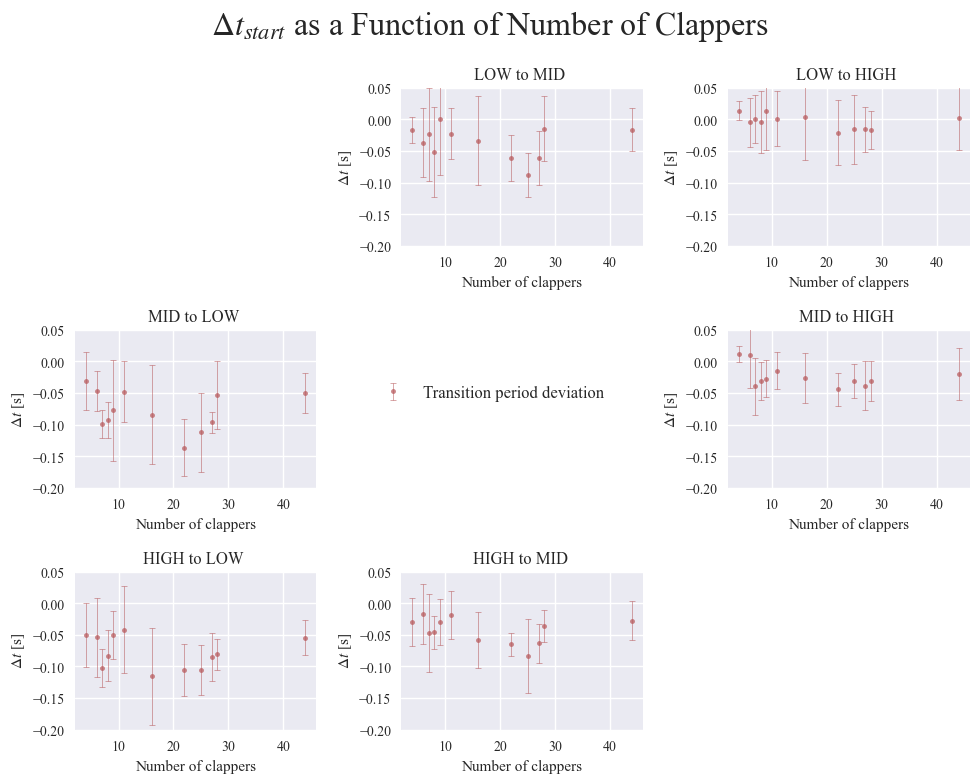

In [1137]:
fig, ax = dev_n_t_plot(dev_dict)
fig.suptitle('$\Delta t_{start}$ as a Function of Number of Clappers', fontsize=23)
fig.tight_layout()
fig.savefig('figurer/rapport/time_dev_start_vs_N', dpi=200)

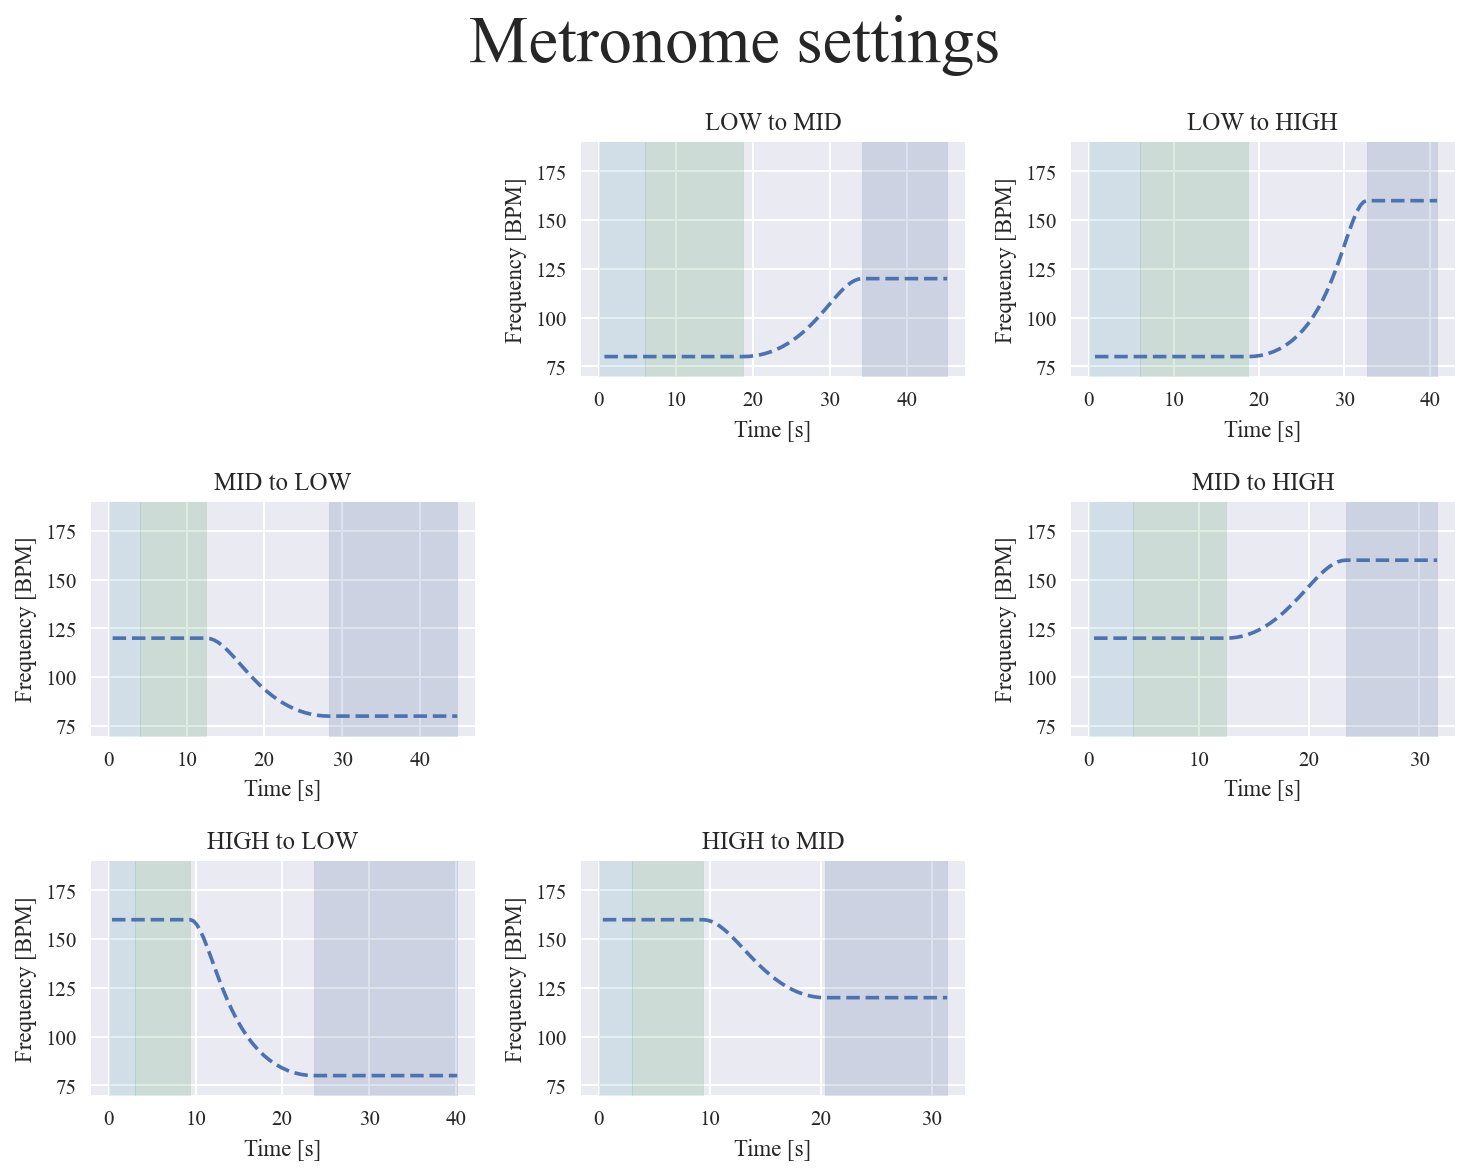

In [999]:
# Plotting the sigmoid function for each setting

fig_sig, ax_sig = plt.subplots(3,3, figsize=(10,8), dpi=150)
ax_sig = ax_sig.flatten()

bpm_tuples = [(80, 120), (80, 160), (120, 80), (120, 160), (160, 80), (160, 120)]


counter = 0
for i in range(len(ax_sig)):
    if i % 4 != 0:
        sig_x = np.linspace(0, 40, 72)
        p_list = p_func(sig_x, threshold_l = 24, threshold_h = 48)
        sig_y = 60 / interval_calc(*bpm_tuples[counter], p_list)
        cum_int = np.cumsum(interval_calc(*bpm_tuples[counter], p_list))
        ax_sig[i].plot(cum_int, sig_y, marker='', ls='--', label='Sigmoid for bpm = {}'.format(bpm_tuples[counter]))
        ax_sig[i].set(xlabel = ('Time [s]'), ylabel = ('Frequency [BPM]'))

        diff = abs(np.diff(sig_y))
        trans_start = np.where(diff > 0)[0][0] 
        trans_end = np.where(diff > 0)[0][-1]
        init = bpm_tuples[counter][0]
        final = bpm_tuples[counter][1]
        sorted = np.sort(bpm_tuples[counter])

        # color start and end preiods
        ax_sig[i].fill_between((cum_int[7], cum_int[trans_start]), -10, 200, color=colors[6], alpha=0.2)
        ax_sig[i].fill_between((cum_int[trans_end + 1], cum_int[-1]), -10, 200, color=colors[8], alpha=0.2)
        ax_sig[i].fill_between((0, cum_int[7]), -10, 200, color=colors[0], alpha=0.2)
       
        ax_sig[i].set_ylim(70, 190)


        if init == 80 and final == 120:
            ax_sig[i].set_title('LOW to MID')
        elif init == 80 and final == 160:
            ax_sig[i].set_title('LOW to HIGH')
        elif init == 120 and final == 80:
            ax_sig[i].set_title('MID to LOW')
        elif init == 120 and final == 160:
            ax_sig[i].set_title('MID to HIGH')
        elif init == 160 and final == 80:
            ax_sig[i].set_title('HIGH to LOW')
        else:
            ax_sig[i].set_title('HIGH to MID')
        
        counter += 1


    else: 
        ax_sig[i].set_visible(False)

fig_sig.suptitle('Metronome settings', fontsize=32)
fig_sig.tight_layout()

#fig_sig.savefig('figurer/rapport/metronome_settings.png')


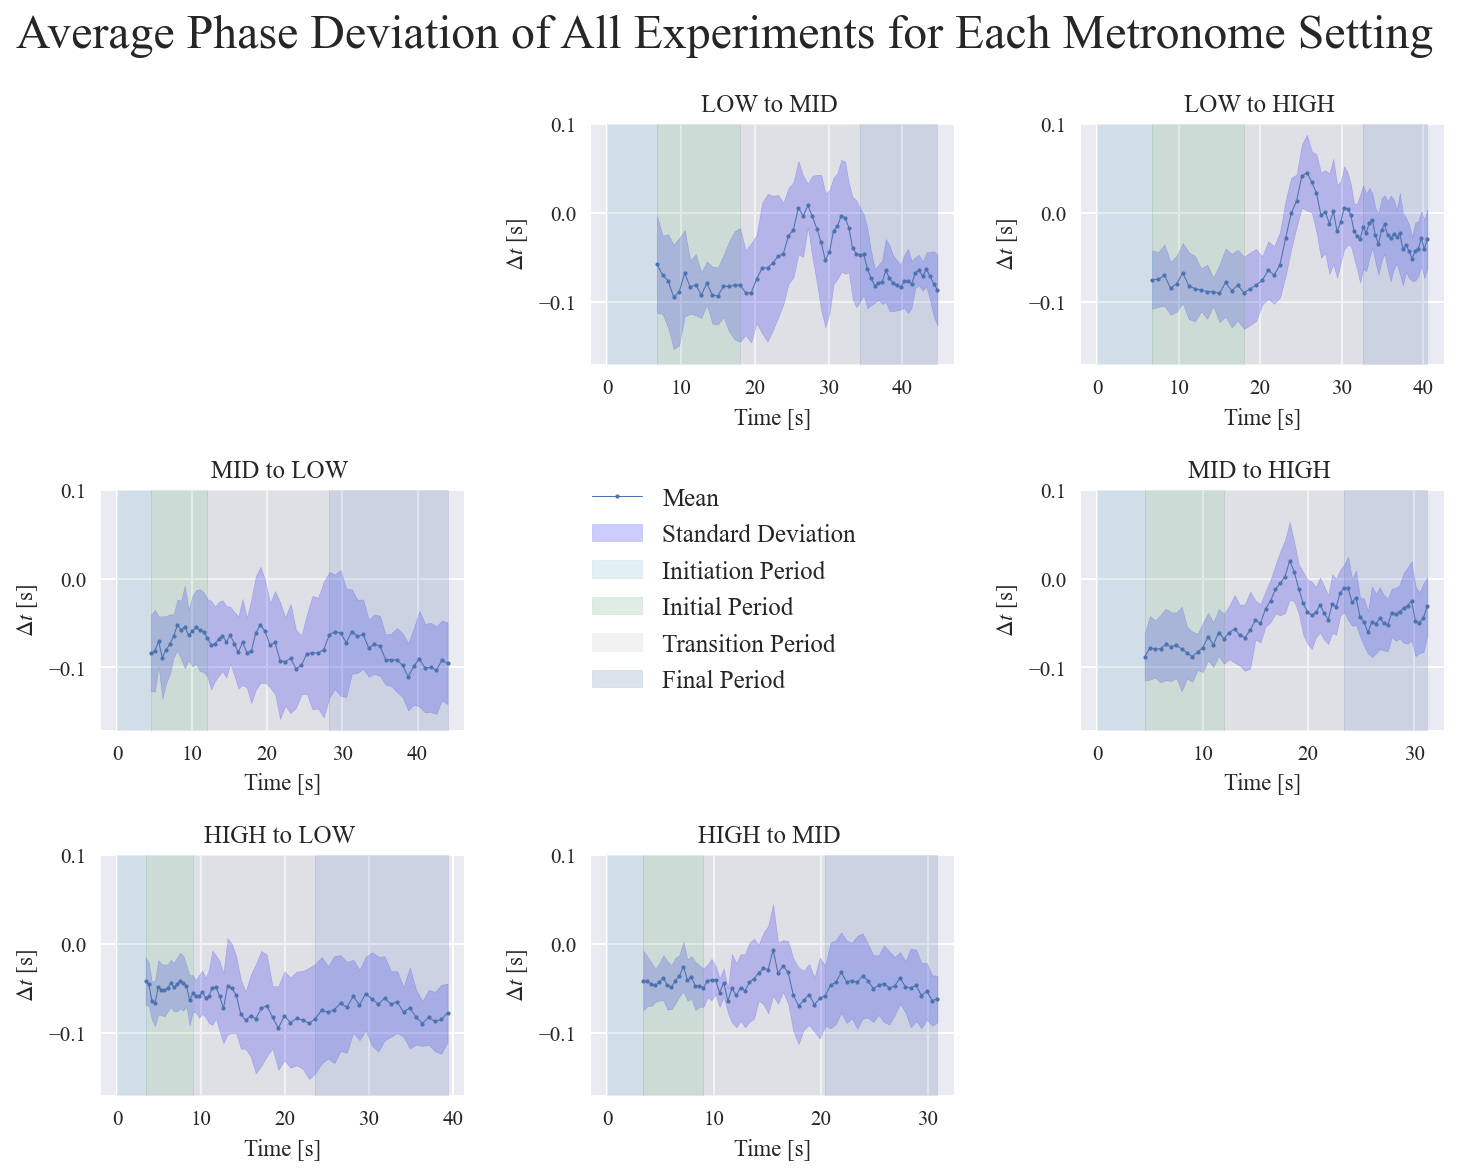

In [1086]:
# (data_met_dev, start_dev_list, trans_dev_list, end_dev_list, time_dev_list, time_start_dev_list, time_trans_dev_list, time_end_dev_list, std_list)

dict_values = list(dev_dict.values())

dt_list_comb = [[] for i in range(6)]

start_dev_list_comb = []
trans_dev_list_comb = []
end_dev_list_comb = []

for n_exp in range(len(dict_values)):
    for setting in range(6):
        dt_list_comb[setting].append(dict_values[n_exp][4][setting])


mean_dt_list = []
std_dt_list = []
minimum_dt_list = []
maximum_dt_list = []
for setting in range(6):
    mean_dt_list.append(np.mean(dt_list_comb[setting], axis = 0))
    std_dt_list.append(np.std(dt_list_comb[setting], axis = 0))
    minimum_dt_list.append(np.min(dt_list_comb[setting], axis = 0))
    maximum_dt_list.append(np.max(dt_list_comb[setting], axis = 0))

    start_dev_list_comb.append((np.mean(mean_dt_list[setting][:7]), np.std(mean_dt_list[setting][:7])))
    trans_dev_list_comb.append((np.mean(mean_dt_list[setting][7:40]), np.std(mean_dt_list[setting][7:40])))
    end_dev_list_comb.append((np.mean(mean_dt_list[setting][40:]), np.std(mean_dt_list[setting][40:])))

fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=150)
ax = ax.flatten()
bpm_tuples = [(80, 120), (80, 160), (120, 80), (120, 160), (160, 80), (160, 120)]

counter = 0

props = dict(boxstyle='round', facecolor='white', edgecolor = 'k', alpha=0.7, pad = 0.5)

for i in range(len(ax)):

    if i % 4 != 0:

        met_filenames = ['low_mid', 'low_high',
                 'mid_low', 'mid_high',
                 'high_low', 'high_mid']

        name = met_filenames[counter].split('_')
        finished_name = ''
        for n in name:
            n = n.upper()
            finished_name += n + ' to '
        finished_name = finished_name[:-3] 
        
        met_claps = np.arange(1, 72, 1)
        p_list = p_func(met_claps, threshold_l = 24, threshold_h = 48)
        cum_int = np.cumsum(interval_calc(*bpm_tuples[counter], p_list)[8:]) + sum(interval_calc(*bpm_tuples[counter], p_list)[:8])
        #print(np.max(cum_int))
        
        if i == 2:
            mean_label = 'Mean'
            std_label = 'Standard Deviation'
            light_blue_label = 'Initiation Period'
            green_label = 'Initial Period'
            white_label = 'Transition Period'
            blue_label = 'Final Period'


        else:
            mean_label = '_nolegend_'
            std_label = '_nolegend_'
            light_blue_label = '_nolegend_'
            green_label = '_nolegend_'
            white_label = '_nolegend_'
            blue_label = '_nolegend_'


        ax[i].plot(cum_int, mean_dt_list[counter], marker='.', ls='-', label = mean_label, linewidth = 0.5, markersize = 4)
        #ax[i].fill_between(cum_int, minimum_dt_list[counter], maximum_dt_list[counter], alpha=0.2, label = 'Min-Max', color='blue')
        ax[i].fill_between(cum_int, mean_dt_list[counter] - std_dt_list[counter], mean_dt_list[counter] + std_dt_list[counter], alpha=0.2, label = std_label, color='blue')
    
        
        #ax[i].legend()

        textstr = '\n'.join((
                r'$\Delta t_{start}=%.2f \pm %.2f$' % (start_dev_list_comb[counter][0], start_dev_list_comb[counter][1]),
                r'$\Delta t_{trans}=%.2f \pm %.2f$' % (trans_dev_list_comb[counter][0], trans_dev_list_comb[counter][1]),
                r'$\Delta t_{end}=%.2f \pm %.2f$' % (end_dev_list_comb[counter][0], end_dev_list_comb[counter][1])
                ))

        #ax[i].text(0.3, 0.75, textstr, transform=ax[i].transAxes, fontsize=8, bbox=props)

        # color start and end preiods
        sig_y = 60 / interval_calc(*bpm_tuples[counter], p_list)
        cum_int = np.cumsum(interval_calc(*bpm_tuples[counter], p_list))
        

        diff = abs(np.diff(sig_y))
        trans_start = np.where(diff > 0)[0][0] 
        trans_end = np.where(diff > 0)[0][-1]
        init = bpm_tuples[counter][0]
        final = bpm_tuples[counter][1]
        sorted = np.sort(bpm_tuples[counter])

        ax[i].fill_between((0, cum_int[8]), -0.2, 0.2, color=colors[0], alpha=0.2, label = light_blue_label)
        ax[i].fill_between((cum_int[8], cum_int[trans_start -1]), -0.2, 0.1, color=colors[6], alpha=0.2, label = green_label)
        ax[i].fill_between((cum_int[trans_start -1], cum_int[trans_end + 1]), -0.2, 0.1, color='grey', alpha=0.1, label = white_label)
        ax[i].fill_between((cum_int[trans_end + 1], cum_int[-1]), -0.2, 0.1, color=colors[8], alpha=0.2, label = blue_label)
        
        ax[i].set(xlabel = ('Time [s]'), ylabel = (r'$\Delta t$ [s]'), title = finished_name)
        ax[i].set(ylim=(-0.17, 0.1))

        counter += 1

    else:
        ax[i].set_visible(False)

fig.legend(loc='center', bbox_to_anchor=(0.5, 0.5), ncol=1, fontsize=12)
fig.suptitle('Average Phase Deviation of All Experiments for Each Metronome Setting', fontsize=23)
fig.tight_layout()

fig.savefig('figurer/rapport/avg_time_dev_vs_time.png')